# 3D data reduction of J1825 and J1826 region

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
from pathlib import Path
import os
import numpy as np
from scipy.stats import chi2
from scipy.stats import norm
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.visualization.wcsaxes import SphericalCircle
from regions import CircleSkyRegion
import scipy
#log = logging.getLogger(__name__)
from skimage.filters import apply_hysteresis_threshold
import warnings
warnings.filterwarnings('ignore')

In [3]:
from gammapy.data import DataStore
from gammapy.datasets import MapDataset
from gammapy.maps import WcsGeom, MapAxis, Map
from gammapy.makers import MapDatasetMaker, SafeMaskMaker, FoVBackgroundMaker
from gammapy.modeling.models import (
    SkyModel,
    PowerLawSpectralModel,
    GaussianSpatialModel)
# from gammapy.utils.regions import make_region
from gammapy.catalog import SourceCatalogHGPS
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators.utils import find_peaks
from gammapy.modeling.models import Models
from gammapy.visualization import plot_spectrum_datasets_off_regions

In [4]:
# analysis_dir = "/home/visitor_ap3/bridge_he"
# plot_dir = "/home/visitor_ap3/bridge_he/reduction_files"
# catalog_filename = "/home/visitor_ap3/bridge_he/catalog/hgps_catalog_v1.fits"
# #exclusion_filename = "/home/visitor_ap3/bridge_he/catalog/Ex_LARGE_det_zeta.fits"
# exclusion_filename = "/home/visitor_ap3/bridge_he/catalog/Ex_SMALL_det_zeta.fits"
# #exclusion_filename = "/home/visitor_ap3/bridge_he/catalog/Ex_STANDARD_det_zeta.fits"
# data_directory = "/home/visitor_ap3/hess_fits/hap-fr/Prod17_Calib0834/he_stereo_Prod17_Calib0834_thsq64"

In [5]:
analysis_dir = "/home/khelifi/MesProgrammes/pyperso/HESSJ1825_HESSJ1826"
plot_dir = "/home/khelifi/MesProgrammes/pyperso/HESSJ1825_HESSJ1826/reduction_files"
catalog_filename = "/home/khelifi/HESS/data/HGPS/hgps_catalog_v1.fits.gz"
exclusion_filename = "/home/khelifi/HESS/data/HGPS/Ex_SMALL_det_zeta.fits"
data_directory = "/home/khelifi/HESS/data/hap-16-03_fitscl7/Prod17_Calib0834/he_stereo_Prod17_Calib0834_thsq64/"

In [6]:
dpi = 500
figsize = (9,6)
label_fontsize = 14
High_Thres = 4
Low_Thres = 3

# Create the observation list to be used in the reduction

In [7]:
data_store = DataStore.from_dir(data_directory)
table = data_store.obs_table

pos_obs = SkyCoord(table['RA_OBJ'], table['DEC_OBJ'], frame='icrs', unit='deg')
center_pos = SkyCoord(276.45, -13.78, unit="deg", frame="icrs")

offset = center_pos.separation(pos_obs).deg
table = table[(offset < 5.5)]

obs_ids = table['OBS_ID']

obs_cols = ["OBS_ID", "GLON_PNT", "GLAT_PNT", "LIVETIME", "ONTIME", "ZEN_PNT"]
selected_obs_table = data_store.obs_table.select_obs_id(obs_ids)[obs_cols]
selected_obs_table

OBS_ID,GLON_PNT,GLAT_PNT,LIVETIME,ONTIME,ZEN_PNT
,deg,deg,s,s,deg
int64,float32,float32,float32,float32,float32
20881,23.19983,0.00027186502,1548.7451,1681.0,25.75476
20903,22.499828,0.0002721382,1546.6735,1681.0,15.271278
20904,21.799828,0.0002750082,1544.955,1681.0,13.827133
20905,21.099829,0.00027326393,1545.9528,1681.0,16.101364
20906,20.399828,0.00027358218,1550.2623,1682.0,21.106537
20907,19.699827,0.00027435907,1554.069,1681.0,27.21875
20908,23.199827,-0.99972546,1560.5677,1681.0,32.988213
20926,18.999828,0.0002729433,1552.7144,1681.0,15.388924


In [8]:
offsets = []
zeniths = []
myobservations = data_store.get_observations(obs_ids)
for obs in myobservations:
    offset = center_pos.separation(obs.pointing_radec)
    offsets.append(offset.value)
    zeniths.append(obs.pointing_zen.value)

No HDU found matching: OBS_ID = 20881, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20903, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20904, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20905, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20906, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20907, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20908, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20926, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20927, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20928, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20947, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20948, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20949, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found

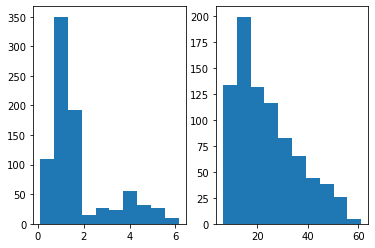

In [9]:
# print(len(offsets),len(zeniths))
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(offsets);
ax2.hist(zeniths);

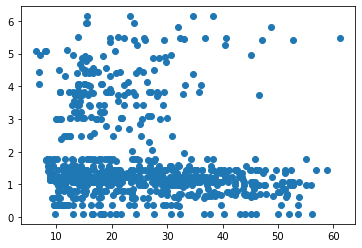

In [10]:
plt.scatter(zeniths, offsets);

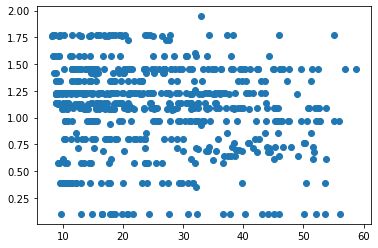

In [11]:
offsets2=[offsets[idx] for idx, x in enumerate(offsets) if x<2.]
zeniths2=[zeniths[idx] for idx, x in enumerate(offsets) if x<2.]
plt.scatter(zeniths2, offsets2);

In [12]:
run_list = open("run_list.txt", 'w')

for run in obs_ids:
    run_list.write(f"{run}\n")

run_list.close()

### Total ontime

In [13]:
selected_obs_table = data_store.obs_table.select_obs_id(obs_ids)[obs_cols]
selected_obs_table
print("Total ontime - "+ str(np.around(sum(selected_obs_table["ONTIME"])/86400.0, 2)) + " days")

Total ontime - 16.57 days


### Histogram of the zenith angle

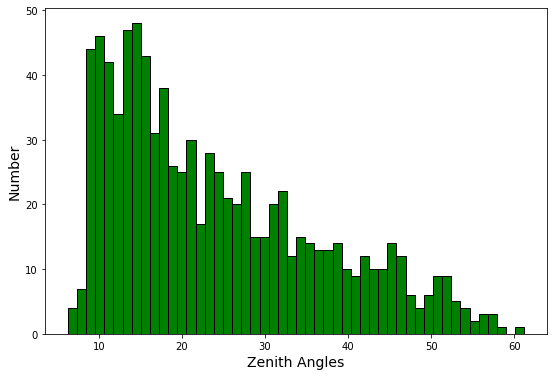

In [14]:
plt.figure(figsize=figsize)
plt.hist(selected_obs_table["ZEN_PNT"], density=False, bins=50, color = "green", ec="black")
plt.ylabel('Number', fontsize=label_fontsize)
plt.xlabel('Zenith Angles', fontsize=label_fontsize)
plt.savefig(os.path.join(plot_dir,'histo.png'), dpi=dpi, bbox_inches='tight')

2.10606249   2.36008624
   2.64474919   2.96374689   3.32122066   3.7218113    4.17071938
   4.67377272   5.23750209   5.86922594   6.57714548   7.37045108
   8.25944161   9.25565817  10.37203387  11.62306177  13.02498301
  14.59599765  16.35650099  18.3293483   20.54015154  23.01761189
  25.79389232  28.90503516  32.39143001  36.29833806  40.67647972
  45.58269306  51.08067171  57.24179172  64.14603822  71.88304375
  80.55325196  90.26922154 101.15708751 113.35819872]## Define the geometry

In [15]:
# Elow, Ehigh = 0.8, 110.0
# energy_axis = MapAxis.from_energy_bounds(Elow, Ehigh, nbin=16, unit="TeV") # he
# energy_axis.edges

In [16]:
observations = data_store.get_observations(obs_ids)

# Elow, Ehigh = 1.0, 100.0
Elow, Ehigh = 2.0, 120.0
energy_axis = MapAxis.from_energy_bounds(Elow, Ehigh, per_decade=True, nbin=5, unit="TeV") # he

geom = WcsGeom.create(
    skydir=center_pos,
    binsz=0.02,
    width=(8, 8),
    frame="icrs",
    proj="CAR",
    axes=[energy_axis])

# Reduced IRFs are defined in true energy (i.e. not measured energy).
energy_axis_true = MapAxis.from_energy_bounds(
    0.1, 125.0, per_decade=True, nbin=15, unit="TeV", name="energy_true")

stacked_iter1 = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name="stacked1")

stacked_iter2 = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name="stacked2")

stacked_iter3 = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name="stacked3")

stacked_iter4 = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name="stacked4")

No HDU found matching: OBS_ID = 20881, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20903, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20904, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20905, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20906, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20907, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20908, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20926, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20927, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20928, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20947, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20948, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20949, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found

In [17]:
# print(energy_axis.edges)

### Find sources SourceCatalogHGPS inside the ROI 

In [18]:
cat = SourceCatalogHGPS(catalog_filename)
indexes = list(range(len(cat.positions)))
indexes 

mask_sources = []
for index in indexes:
    if center_pos.separation(cat.positions[index]).value<=3:
           mask_sources.append(cat.source_name(index))
            
for source in mask_sources:
    try:
        print(source,',', cat[source].spatial_model(), '\n\n')
    except:
        print(source,',', cat[source].sky_model(), '\n\n')

HESS J1818-154 , GaussianSpatialModel

  type   name   value    unit   error      min        max    frozen link
------- ----- ---------- ---- --------- ---------- --------- ------ ----
spatial lon_0 1.5407e+01  deg 9.591e-03        nan       nan  False     
spatial lat_0 1.5874e-01  deg 9.316e-03 -9.000e+01 9.000e+01  False     
spatial sigma 0.0000e+00  deg 0.000e+00  0.000e+00       nan  False     
spatial     e 0.0000e+00      0.000e+00  0.000e+00 1.000e+00   True     
spatial   phi 0.0000e+00  deg 0.000e+00        nan       nan   True      


HESS J1825-137 , SkyModel

  Name                      : HESS J1825-137
  Datasets names            : None
  Spectral model type       : PowerLawNormSpectralModel
  Spatial  model type       : TemplateSpatialModel
  Temporal model type       : 
  Parameters:
    norm                    :      1.000   +/-    0.00             
    tilt         (frozen)   :      0.000                   
    reference    (frozen)   :      1.000       TeV         


### Create exclusion mask

Invalid value BUNIT='Count' in FITS header. Setting empty unit.


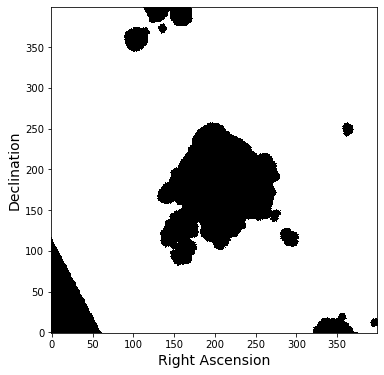

In [19]:
# Read exclusion file and creat map
mask_map = Map.read(exclusion_filename)
mask_map.data = mask_map.data.astype(bool)
#mask_map_cut = mask_map.cutout(center_pos, width=[6*u.deg, 6*u.deg])
mask_map = mask_map.interp_to_geom(geom)

plt.figure(figsize=figsize)
ax=plt.subplot(111)
mask_map.sum_over_axes().plot(ax=ax)
plt.ylabel('Declination', fontsize=label_fontsize)
plt.xlabel('Right Ascension', fontsize=label_fontsize)
plt.savefig(os.path.join(plot_dir,'exclusion_masks_iter1.png'), dpi=dpi, bbox_inches='tight')

## Define makers

In [20]:
from gammapy.modeling.models import PowerLawNormSpectralModel
# modify default value on the class level
PowerLawNormSpectralModel.tilt.frozen = False
pwl = PowerLawNormSpectralModel()
print(pwl)

PowerLawNormSpectralModel

  type      name     value    unit   error   min max frozen link
-------- --------- ---------- ---- --------- --- --- ------ ----
spectral      norm 1.0000e+00      0.000e+00 nan nan  False     
spectral      tilt 0.0000e+00      0.000e+00 nan nan  False     
spectral reference 1.0000e+00  TeV 0.000e+00 nan nan   True     


In [21]:
offset_max = 2.0 * u.deg
maker = MapDatasetMaker()
maker_safe_mask = SafeMaskMaker(methods=["aeff-max", 'aeff-default', "offset-max", "bkg-peak"],
                                offset_max=offset_max, aeff_percent=15)

maker_fov = FoVBackgroundMaker(method="fit", exclusion_mask=mask_map, min_counts=50)

# Run the data reduction loop 1

In [22]:
path = Path(plot_dir)
path.mkdir(exist_ok=True)

bkg_norms_iter1 = open(path /  f"bkg_norms_iter1.txt", 'w')
prb_runs_iter1 = open(path /  f"prb_runs_iter1.txt", 'w')

In [23]:
# from regions import CircleSkyRegion
# from astropy.coordinates import Angle
# on_region_radius = Angle("2.0 deg")
# onregion = CircleSkyRegion(center=center_pos, radius=on_region_radius)

In [24]:
%%time

Ethres = []
ii = 0
for obs in observations:
    try:
     # First a cutout of the target map is produced
        cutout = stacked_iter1.cutout(
        obs.pointing_radec, width=2 * offset_max, name=f"obs-{obs.obs_id}", mode="partial") 
    # A MapDataset is filled in this cutout geometry
        dataset_iter1 = maker.run(cutout, obs)
    # The data quality cut is applied
        dataset_iter1 = maker_safe_mask.run(dataset_iter1, obs)
    # Get safe threshold
        min_value = -1
        try:
            min_map, max_map = dataset_iter1.energy_range
            min_value = min_map.get_by_coord(obs.pointing_radec)
        except:
            print(f"No min energy (#{obs.obs_id})")
#         print(f"obs-{obs.obs_id} Zen={obs.pointing_zen} Offset={center_pos.separation(obs.pointing_radec):.2f} min_value={min_value}")
#         sp_dataset = dataset_iter1.to_spectrum_dataset(onregion)
#         print(sp_dataset)
#         sp_dataset.plot_fit()
        
    # fit background model
        dataset_iter1 = maker_fov.run(dataset_iter1)
        norm = dataset_iter1.models[0].spectral_model.norm.value
        norm_err = dataset_iter1.models[0].spectral_model.norm.error
        tilt = dataset_iter1.models[0].spectral_model.tilt.value
        tilt_err = dataset_iter1.models[0].spectral_model.tilt.error
       #print(
       # f"Background norm obs {obs.obs_id}: {dataset_iter1.background_model.parameters['norm'].value:.2f}")
    #if the background norm is completely off scale don't stack run
        if np.abs(norm-1.)>0.5:
            print(f"Dropping run #{obs.obs_id}- Bad norm (n={norm:.2f}).")
            continue
        if norm_err/norm>0.25:
            print(f"Dropping run #{obs.obs_id}- Large error on norm (n_err/n={norm_err/norm:.2f}).")
            continue
        if tilt_err/tilt>0.2:
           print(f"Dropping run  #{obs.obs_id}- Large error on tilt (t_err/t={tilt_err/tilt}).")
           continue
       #if np.abs(tilt)>0.5:
        #   print("Dropping run - Bad tilt.")
        #   continue
        bkg_norms_iter1.write(f"{norm} \t {norm_err} \t {tilt}\n") 
       #print(dataset_iter1.background_model.parameters["norm"].value, dataset_iter1.background_model.parameters["tilt"].value)
     # The resulting dataset cutout is stacked onto the final one
        stacked_iter1.stack(dataset_iter1)

        if not np.isnan(min_value) and min_value>0:
            Ethres.append(min_value)

    except:
        prb_runs_iter1.write(f"Error with {obs.obs_id} (run too far)\n")
        print(f"Error with {obs.obs_id}")
        pass

    ii += 1
#     if ii>5:
#         break

bkg_norms_iter1.close()
prb_runs_iter1.close()

FoVBackgroundMaker failed. Only 18 counts outside exclusion mask for obs-20881. Setting mask to False.


Error with 20881


FoVBackgroundMaker failed. Only 47 counts outside exclusion mask for obs-20903. Setting mask to False.


Error with 20903
Dropping run #20904- Bad norm (n=2.67).
Dropping run  #20905- Large error on tilt (t_err/t=1.108386910056736).
Dropping run #20906- Bad norm (n=1.54).
Dropping run #20908- Bad norm (n=1.85).
Dropping run #20926- Bad norm (n=1.80).
Dropping run #20927- Bad norm (n=3.10).
Dropping run  #20928- Large error on tilt (t_err/t=18.337371274491087).
Dropping run #20947- Bad norm (n=1.72).
Dropping run #20948- Bad norm (n=1.59).
Dropping run  #20949- Large error on tilt (t_err/t=10.623986028702005).
Dropping run #20950- Large error on norm (n_err/n=0.31).
Dropping run #20964- Bad norm (n=1.90).
Dropping run #20965- Bad norm (n=1.68).
Dropping run #21195- Bad norm (n=1.95).
Dropping run #21220- Bad norm (n=2.87).
Dropping run #21301- Bad norm (n=1.72).
Dropping run #21396- Bad norm (n=1.55).
Dropping run #21528- Large error on norm (n_err/n=0.25).


FoVBackgroundMaker failed. Only 43 counts outside exclusion mask for obs-21545. Setting mask to False.


Error with 21545
Dropping run #21548- Bad norm (n=1.63).
Dropping run #21564- Bad norm (n=2.23).
Dropping run #21571- Bad norm (n=2.25).
Dropping run #21590- Large error on norm (n_err/n=0.26).
Dropping run #21604- Large error on norm (n_err/n=0.34).
Dropping run #21605- Bad norm (n=1.85).
Dropping run #21624- Bad norm (n=2.07).
Dropping run #21697- Large error on norm (n_err/n=0.36).
Dropping run #21700- Bad norm (n=1.74).
Dropping run #21718- Large error on norm (n_err/n=0.38).
Dropping run #21743- Large error on norm (n_err/n=0.39).
Dropping run #21747- Bad norm (n=1.86).
Dropping run #21767- Bad norm (n=1.57).
Dropping run #21768- Large error on norm (n_err/n=0.29).
Dropping run #21785- Bad norm (n=1.74).
Dropping run #21786- Large error on norm (n_err/n=0.33).
Dropping run #21803- Large error on norm (n_err/n=0.27).
Dropping run #22168- Large error on norm (n_err/n=0.30).
Dropping run #22169- Bad norm (n=1.68).
Dropping run #22170- Large error on norm (n_err/n=0.34).
Dropping run 

FoVBackgroundMaker failed. Only 20 counts outside exclusion mask for obs-22305. Setting mask to False.


Error with 22305
Dropping run #22306- Large error on norm (n_err/n=0.37).


FoVBackgroundMaker failed. Only 33 counts outside exclusion mask for obs-22307. Setting mask to False.


Error with 22307


FoVBackgroundMaker failed. Only 12 counts outside exclusion mask for obs-22318. Setting mask to False.


Error with 22318
Dropping run #22319- Large error on norm (n_err/n=0.37).


FoVBackgroundMaker failed. Only 21 counts outside exclusion mask for obs-22320. Setting mask to False.


Error with 22320
Dropping run #22321- Bad norm (n=1.82).
Dropping run  #22324- Large error on tilt (t_err/t=0.9948669721242999).
Dropping run #22336- Large error on norm (n_err/n=0.41).
Dropping run #22337- Large error on norm (n_err/n=0.39).
Dropping run #22338- Large error on norm (n_err/n=0.34).
Dropping run #22339- Large error on norm (n_err/n=0.29).
Dropping run #22340- Bad norm (n=1.63).
Dropping run  #22341- Large error on tilt (t_err/t=9.751669036212382).


FoVBackgroundMaker failed. Only 35 counts outside exclusion mask for obs-22352. Setting mask to False.


Error with 22352


FoVBackgroundMaker failed. Only 42 counts outside exclusion mask for obs-22353. Setting mask to False.


Error with 22353


FoVBackgroundMaker failed. Only 38 counts outside exclusion mask for obs-22370. Setting mask to False.


Error with 22370
Dropping run #22371- Large error on norm (n_err/n=0.34).


FoVBackgroundMaker failed. Only 21 counts outside exclusion mask for obs-22405. Setting mask to False.


Error with 22405


FoVBackgroundMaker failed. Only 17 counts outside exclusion mask for obs-22406. Setting mask to False.


Error with 22406


FoVBackgroundMaker failed. Only 18 counts outside exclusion mask for obs-22408. Setting mask to False.


Error with 22408


FoVBackgroundMaker failed. Only 4 counts outside exclusion mask for obs-22473. Setting mask to False.


Error with 22473


FoVBackgroundMaker failed. Only 13 counts outside exclusion mask for obs-22520. Setting mask to False.


Error with 22520


FoVBackgroundMaker failed. Only 31 counts outside exclusion mask for obs-22521. Setting mask to False.


Error with 22521


FoVBackgroundMaker failed. Only 11 counts outside exclusion mask for obs-22522. Setting mask to False.


Error with 22522
Dropping run #23024- Large error on norm (n_err/n=0.32).
Dropping run #23025- Bad norm (n=0.49).


FoVBackgroundMaker failed. Only 12 counts outside exclusion mask for obs-23048. Setting mask to False.


Error with 23048
Dropping run #23050- Large error on norm (n_err/n=0.38).
Dropping run #25015- Bad norm (n=1.59).
Dropping run #25016- Large error on norm (n_err/n=0.33).
Dropping run #25019- Large error on norm (n_err/n=0.43).


FoVBackgroundMaker failed. Only 42 counts outside exclusion mask for obs-25020. Setting mask to False.


Error with 25020
Dropping run  #25035- Large error on tilt (t_err/t=2.4004179335005067).
Dropping run #25036- Bad norm (n=2.01).
Dropping run #25037- Bad norm (n=1.69).
Dropping run #25038- Bad norm (n=1.96).
Dropping run #25050- Bad norm (n=1.73).
Dropping run #25051- Large error on norm (n_err/n=0.29).
Dropping run #25052- Bad norm (n=1.76).
Dropping run #25053- Large error on norm (n_err/n=0.38).
Dropping run #25063- Bad norm (n=2.38).
Dropping run  #25095- Large error on tilt (t_err/t=0.7820118939408114).
Dropping run #25096- Large error on norm (n_err/n=0.33).
Dropping run #25103- Large error on norm (n_err/n=0.27).
Dropping run #25104- Large error on norm (n_err/n=0.33).


FoVBackgroundMaker failed. Only 47 counts outside exclusion mask for obs-25354. Setting mask to False.


Error with 25354


FoVBackgroundMaker failed. Only 46 counts outside exclusion mask for obs-25381. Setting mask to False.


Error with 25381
Dropping run #25382- Large error on norm (n_err/n=0.37).
Dropping run #25426- Large error on norm (n_err/n=0.30).
Dropping run #25427- Bad norm (n=4.81).
Dropping run #25428- Large error on norm (n_err/n=0.45).
Dropping run #25429- Large error on norm (n_err/n=0.38).
Dropping run #25431- Large error on norm (n_err/n=0.37).


FoVBackgroundMaker failed. Only 49 counts outside exclusion mask for obs-25432. Setting mask to False.


Error with 25432
Dropping run #25454- Large error on norm (n_err/n=0.35).
Dropping run #25455- Large error on norm (n_err/n=0.39).


FoVBackgroundMaker failed. Only 42 counts outside exclusion mask for obs-25456. Setting mask to False.


Error with 25456
Dropping run #25457- Large error on norm (n_err/n=0.32).
Dropping run #25458- Bad norm (n=2.01).
Dropping run #25476- Large error on norm (n_err/n=0.28).
Dropping run #25477- Bad norm (n=1.70).
Dropping run #25478- Bad norm (n=1.55).
Dropping run #25479- Bad norm (n=2.29).


FoVBackgroundMaker failed. Only 33 counts outside exclusion mask for obs-25480. Setting mask to False.


Error with 25480
Dropping run #25481- Bad norm (n=2.05).
Dropping run #25483- Large error on norm (n_err/n=0.25).


FoVBackgroundMaker failed. Only 32 counts outside exclusion mask for obs-25499. Setting mask to False.


Error with 25499
Dropping run #25500- Large error on norm (n_err/n=0.39).


FoVBackgroundMaker failed. Only 36 counts outside exclusion mask for obs-25520. Setting mask to False.


Error with 25520


FoVBackgroundMaker failed. Only 34 counts outside exclusion mask for obs-25521. Setting mask to False.


Error with 25521
Dropping run #25547- Large error on norm (n_err/n=0.40).
Dropping run #25548- Bad norm (n=0.44).


FoVBackgroundMaker failed. Only 41 counts outside exclusion mask for obs-25578. Setting mask to False.


Error with 25578
Dropping run #25592- Large error on norm (n_err/n=0.39).
Dropping run #25593- Bad norm (n=2.44).


FoVBackgroundMaker failed. Only 37 counts outside exclusion mask for obs-25679. Setting mask to False.


Error with 25679


FoVBackgroundMaker failed. Only 38 counts outside exclusion mask for obs-25680. Setting mask to False.


Error with 25680
Dropping run #26130- Bad norm (n=1.53).
Dropping run #26131- Bad norm (n=2.31).
Dropping run #26161- Large error on norm (n_err/n=0.44).
Dropping run #26179- Bad norm (n=2.06).
Dropping run #26180- Large error on norm (n_err/n=0.30).
Dropping run #26182- Bad norm (n=1.61).
Dropping run #26183- Bad norm (n=2.96).
Dropping run #26184- Bad norm (n=1.62).
Dropping run #26185- Bad norm (n=1.60).
Dropping run #26206- Large error on norm (n_err/n=0.28).
Dropping run #26207- Large error on norm (n_err/n=0.31).
Dropping run #26208- Bad norm (n=1.64).
Dropping run #26209- Large error on norm (n_err/n=0.26).
Dropping run #26237- Bad norm (n=2.06).
Dropping run #26239- Large error on norm (n_err/n=0.37).
Dropping run #26240- Large error on norm (n_err/n=0.33).
Dropping run #26241- Bad norm (n=1.65).


FoVBackgroundMaker failed. Only 2 counts outside exclusion mask for obs-26242. Setting mask to False.


Error with 26242


FoVBackgroundMaker failed. Only 49 counts outside exclusion mask for obs-26256. Setting mask to False.


Error with 26256


FoVBackgroundMaker failed. Only 38 counts outside exclusion mask for obs-26257. Setting mask to False.


Error with 26257


FoVBackgroundMaker failed. Only 8 counts outside exclusion mask for obs-26258. Setting mask to False.


Error with 26258
Dropping run #26259- Bad norm (n=1.87).


FoVBackgroundMaker failed. Only 49 counts outside exclusion mask for obs-26882. Setting mask to False.


Error with 26882


FoVBackgroundMaker failed. Only 38 counts outside exclusion mask for obs-26883. Setting mask to False.


Error with 26883
Dropping run #26885- Large error on norm (n_err/n=0.37).
Dropping run #26916- Bad norm (n=1.82).
Dropping run #26917- Bad norm (n=1.61).
Dropping run #26918- Bad norm (n=2.58).
Dropping run #26919- Bad norm (n=1.75).
Dropping run #26920- Bad norm (n=1.77).
Dropping run #26921- Bad norm (n=1.51).
Dropping run #26922- Large error on norm (n_err/n=0.25).
Dropping run #26923- Large error on norm (n_err/n=0.26).
Dropping run #26936- Bad norm (n=2.63).
Dropping run #26937- Bad norm (n=1.80).
Dropping run #26938- Bad norm (n=1.59).
Dropping run #26939- Bad norm (n=2.19).
Dropping run #26940- Bad norm (n=2.77).
Dropping run #26941- Bad norm (n=2.46).
Dropping run #26942- Bad norm (n=1.74).
Dropping run #26943- Bad norm (n=1.78).
Dropping run #26965- Large error on norm (n_err/n=0.34).


FoVBackgroundMaker failed. Only 35 counts outside exclusion mask for obs-26967. Setting mask to False.


Error with 26967
Dropping run #26969- Large error on norm (n_err/n=0.37).
Dropping run #26970- Large error on norm (n_err/n=0.36).
Dropping run #26971- Large error on norm (n_err/n=0.33).
Dropping run #26984- Bad norm (n=2.06).
Dropping run #26985- Large error on norm (n_err/n=0.34).
Dropping run #26986- Bad norm (n=1.61).
Dropping run #26987- Bad norm (n=1.65).


FoVBackgroundMaker failed. Only 48 counts outside exclusion mask for obs-26988. Setting mask to False.


Error with 26988
Dropping run #26989- Large error on norm (n_err/n=0.43).
Dropping run #26990- Bad norm (n=2.14).
Dropping run #26991- Large error on norm (n_err/n=0.36).
Dropping run #26992- Bad norm (n=1.68).
Dropping run #26993- Large error on norm (n_err/n=0.38).


FoVBackgroundMaker failed. Only 5 counts outside exclusion mask for obs-27099. Setting mask to False.


Error with 27099
Dropping run #27100- Large error on norm (n_err/n=0.38).


FoVBackgroundMaker failed. Only 32 counts outside exclusion mask for obs-27101. Setting mask to False.


Error with 27101


FoVBackgroundMaker failed. Only 3 counts outside exclusion mask for obs-27106. Setting mask to False.


Error with 27106
Dropping run #27107- Large error on norm (n_err/n=0.28).
Dropping run #27155- Large error on norm (n_err/n=0.36).
Dropping run #27156- Large error on norm (n_err/n=0.38).
Dropping run #27157- Large error on norm (n_err/n=0.33).
Dropping run #27158- Bad norm (n=1.50).


FoVBackgroundMaker failed. Only 28 counts outside exclusion mask for obs-28385. Setting mask to False.


Error with 28385


FoVBackgroundMaker failed. Only 40 counts outside exclusion mask for obs-28386. Setting mask to False.


Error with 28386


FoVBackgroundMaker failed. Only 48 counts outside exclusion mask for obs-28387. Setting mask to False.


Error with 28387
Dropping run #28388- Large error on norm (n_err/n=0.44).
Dropping run #28389- Large error on norm (n_err/n=0.42).


FoVBackgroundMaker failed. Only 34 counts outside exclusion mask for obs-28417. Setting mask to False.


Error with 28417
Dropping run #28418- Bad norm (n=1.55).
Dropping run #28419- Bad norm (n=1.79).


FoVBackgroundMaker failed. Only 47 counts outside exclusion mask for obs-28420. Setting mask to False.


Error with 28420
Dropping run #28421- Large error on norm (n_err/n=0.33).


FoVBackgroundMaker failed. Only 41 counts outside exclusion mask for obs-28439. Setting mask to False.


Error with 28439
Dropping run #28440- Large error on norm (n_err/n=0.45).
Dropping run #28441- Large error on norm (n_err/n=0.42).
Dropping run #28442- Large error on norm (n_err/n=0.37).
Dropping run #28443- Large error on norm (n_err/n=0.35).
Dropping run #28467- Bad norm (n=2.01).
Dropping run #28468- Large error on norm (n_err/n=0.39).
Dropping run  #29361- Large error on tilt (t_err/t=0.5759178893788716).
Dropping run  #29362- Large error on tilt (t_err/t=1.960128503538464).
Dropping run  #29371- Large error on tilt (t_err/t=0.7305238864587318).
Dropping run #29383- Large error on norm (n_err/n=0.30).
Dropping run #29425- Large error on norm (n_err/n=0.29).
Dropping run  #29440- Large error on tilt (t_err/t=1.0817486750201561).
Dropping run #34646- Bad norm (n=2.36).
Dropping run #34647- Large error on norm (n_err/n=0.33).
Dropping run #34648- Bad norm (n=2.23).
Dropping run #34821- Bad norm (n=2.14).
Dropping run #34824- Bad norm (n=1.54).
Dropping run #34922- Bad norm (n=1.96).


FoVBackgroundMaker failed. Only 35 counts outside exclusion mask for obs-35362. Setting mask to False.


Error with 35362
Dropping run  #38227- Large error on tilt (t_err/t=4.598725474902052).
Dropping run #38229- Bad norm (n=1.74).
Dropping run  #38230- Large error on tilt (t_err/t=4.394283157430526).
Dropping run #38231- Bad norm (n=4.05).
Dropping run  #38260- Large error on tilt (t_err/t=18.49100220233258).
Dropping run #38262- Large error on norm (n_err/n=0.31).
Dropping run #38264- Bad norm (n=1.94).
Dropping run #38265- Bad norm (n=2.16).
Dropping run #38280- Large error on norm (n_err/n=0.30).
Dropping run #38300- Bad norm (n=1.54).
Dropping run  #38325- Large error on tilt (t_err/t=0.8370877644364328).
Dropping run #39576- Large error on norm (n_err/n=0.29).
Dropping run #39577- Large error on norm (n_err/n=0.27).
Dropping run #39579- Bad norm (n=1.54).
Dropping run #39684- Large error on norm (n_err/n=0.28).
Dropping run #39685- Bad norm (n=1.97).
Dropping run #39686- Large error on norm (n_err/n=0.28).
Dropping run #39687- Large error on norm (n_err/n=0.33).
Dropping run #39688

FoVBackgroundMaker failed. Only 45 counts outside exclusion mask for obs-51458. Setting mask to False.


Error with 51458
Dropping run #51662- Large error on norm (n_err/n=0.28).


FoVBackgroundMaker failed. Only 42 counts outside exclusion mask for obs-51663. Setting mask to False.


Error with 51663
Dropping run #51664- Bad norm (n=2.07).
Dropping run #51680- Bad norm (n=2.41).
Dropping run #51681- Large error on norm (n_err/n=0.35).
Dropping run #51682- Bad norm (n=2.32).
Dropping run #51716- Bad norm (n=2.13).
Dropping run #52376- Large error on norm (n_err/n=0.30).
Dropping run #52412- Large error on norm (n_err/n=0.26).
Dropping run #52432- Large error on norm (n_err/n=0.26).
Dropping run #52575- Large error on norm (n_err/n=0.35).
Dropping run #52606- Bad norm (n=1.81).
Dropping run  #52701- Large error on tilt (t_err/t=2.4872956940302973).
Dropping run #52881- Bad norm (n=1.58).
Dropping run #52882- Bad norm (n=1.99).
Dropping run #52883- Bad norm (n=2.30).
Dropping run #52951- Large error on norm (n_err/n=0.28).
Dropping run #52952- Large error on norm (n_err/n=0.32).
Dropping run #52953- Large error on norm (n_err/n=0.31).
Dropping run  #57628- Large error on tilt (t_err/t=1.8689413746846597).
Dropping run #57629- Large error on norm (n_err/n=0.30).
Droppi

FoVBackgroundMaker failed. Only 49 counts outside exclusion mask for obs-59564. Setting mask to False.


Error with 59564
Dropping run #64936- Bad norm (n=1.65).
Dropping run #64965- Bad norm (n=1.63).
Dropping run #64966- Bad norm (n=2.21).
Dropping run #64967- Large error on norm (n_err/n=0.29).
Dropping run #64968- Bad norm (n=1.84).
Dropping run #64969- Large error on norm (n_err/n=0.31).
Dropping run #64999- Bad norm (n=1.56).
Dropping run #65026- Bad norm (n=2.61).
Dropping run #65029- Bad norm (n=1.55).
Dropping run #65030- Bad norm (n=1.63).
Dropping run #65060- Bad norm (n=2.39).
Dropping run #65061- Bad norm (n=1.87).
Dropping run #65062- Large error on norm (n_err/n=0.29).
Dropping run  #65063- Large error on tilt (t_err/t=0.7541719462166665).
Dropping run #65207- Bad norm (n=2.58).
Dropping run #65208- Large error on norm (n_err/n=0.26).
Dropping run #65209- Large error on norm (n_err/n=0.27).
Dropping run #65210- Bad norm (n=1.94).
Dropping run #65211- Bad norm (n=1.66).
Dropping run #65212- Large error on norm (n_err/n=0.27).
Dropping run #65213- Bad norm (n=1.75).
Dropping 

FoVBackgroundMaker failed. Only 47 counts outside exclusion mask for obs-65354. Setting mask to False.


Error with 65354
Dropping run #65359- Bad norm (n=1.56).
Dropping run #65361- Large error on norm (n_err/n=0.28).
Dropping run  #65362- Large error on tilt (t_err/t=0.6936710337930947).
Dropping run #65366- Bad norm (n=1.53).
Dropping run #66614- Bad norm (n=1.91).
Dropping run #66616- Large error on norm (n_err/n=0.26).
Dropping run #66617- Large error on norm (n_err/n=0.33).
Dropping run #66641- Bad norm (n=2.18).
Dropping run #66642- Bad norm (n=1.68).
Dropping run #66643- Large error on norm (n_err/n=0.31).
Dropping run #66665- Bad norm (n=2.23).
Dropping run #66666- Bad norm (n=1.86).
Dropping run #66687- Bad norm (n=1.68).
Dropping run #66688- Bad norm (n=1.55).
Dropping run #66689- Large error on norm (n_err/n=0.39).
Dropping run #66712- Bad norm (n=1.65).
Dropping run #66713- Large error on norm (n_err/n=0.29).
Dropping run #66737- Bad norm (n=1.88).
Dropping run #71846- Large error on norm (n_err/n=0.31).
Dropping run #71920- Large error on norm (n_err/n=0.30).
Dropping run #7

FoVBackgroundMaker failed. Only 42 counts outside exclusion mask for obs-86509. Setting mask to False.


Error with 86509
Dropping run #86510- Large error on norm (n_err/n=0.33).
Dropping run #86511- Bad norm (n=2.17).
Dropping run #86537- Bad norm (n=1.92).
Dropping run #86576- Bad norm (n=1.51).
Dropping run #86577- Bad norm (n=1.60).
Dropping run #87059- Bad norm (n=1.66).
Dropping run #87060- Large error on norm (n_err/n=0.30).
Dropping run  #87061- Large error on tilt (t_err/t=2.3859254528610085).
Dropping run #87062- Large error on norm (n_err/n=0.29).
Dropping run #87063- Large error on norm (n_err/n=0.28).
Dropping run #87082- Bad norm (n=1.92).
Dropping run #87083- Large error on norm (n_err/n=0.33).
Dropping run #87121- Bad norm (n=1.74).
Dropping run #87122- Large error on norm (n_err/n=0.30).
Dropping run #87147- Large error on norm (n_err/n=0.33).
Dropping run #87152- Large error on norm (n_err/n=0.29).
Dropping run #87153- Bad norm (n=1.60).
Dropping run #87193- Bad norm (n=2.07).
Dropping run #87194- Large error on norm (n_err/n=0.36).
Dropping run #87195- Large error on no

FoVBackgroundMaker failed. Only 36 counts outside exclusion mask for obs-106060. Setting mask to False.


Error with 106060
Dropping run #106308- Large error on norm (n_err/n=0.31).
Dropping run #106309- Bad norm (n=1.50).


FoVBackgroundMaker failed. Only 47 counts outside exclusion mask for obs-106361. Setting mask to False.


Error with 106361
Dropping run #106562- Large error on norm (n_err/n=0.33).
Dropping run #107179- Large error on norm (n_err/n=0.32).
Dropping run #107182- Bad norm (n=1.53).
Dropping run  #107183- Large error on tilt (t_err/t=3.401387043984404).
Dropping run #107231- Large error on norm (n_err/n=0.31).
Dropping run #107232- Large error on norm (n_err/n=0.27).
Dropping run #107282- Large error on norm (n_err/n=0.31).
Dropping run #107283- Bad norm (n=1.51).
Dropping run #107284- Bad norm (n=1.73).
Dropping run #107287- Bad norm (n=2.10).
Dropping run #107336- Large error on norm (n_err/n=0.35).
Dropping run #107337- Large error on norm (n_err/n=0.26).
Dropping run #107338- Large error on norm (n_err/n=0.26).
Dropping run  #107701- Large error on tilt (t_err/t=1.1181698303235994).
Dropping run #119893- Bad norm (n=2.78).
Dropping run #120035- Bad norm (n=1.55).
Dropping run #120094- Bad norm (n=1.69).
Dropping run #120099- Bad norm (n=3.51).
Dropping run #120122- Bad norm (n=1.78).
Drop

FoVBackgroundMaker failed. Only 39 counts outside exclusion mask for obs-122189. Setting mask to False.


Error with 122189
Dropping run #122227- Bad norm (n=2.53).
Dropping run #122233- Large error on norm (n_err/n=0.28).
Dropping run #122234- Large error on norm (n_err/n=0.26).
Dropping run #122235- Large error on norm (n_err/n=0.40).
Dropping run #122237- Large error on norm (n_err/n=0.32).
Dropping run #122238- Large error on norm (n_err/n=0.27).
Dropping run #122239- Bad norm (n=1.51).
Dropping run #122285- Large error on norm (n_err/n=0.32).
Dropping run #122287- Bad norm (n=2.34).
Dropping run #122288- Bad norm (n=1.52).
Dropping run #122289- Bad norm (n=1.68).
Dropping run #122290- Bad norm (n=1.83).
Dropping run #122327- Large error on norm (n_err/n=0.30).
Dropping run #122338- Large error on norm (n_err/n=0.25).
Dropping run  #122340- Large error on tilt (t_err/t=1.2568682436234884).
Dropping run #122377- Bad norm (n=2.98).
Dropping run #122417- Bad norm (n=2.62).
Dropping run #122464- Bad norm (n=2.59).
Dropping run #122465- Bad norm (n=1.68).
Dropping run #122911- Large error o

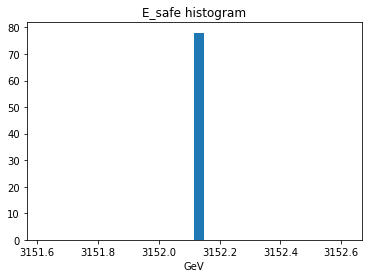

In [25]:
plt.hist(np.asarray(Ethres) * 1.0e3, bins=30);
plt.xlabel('GeV');
plt.title('E_safe histogram')
plt.savefig(os.path.join(plot_dir,'esafe_iter1.png'), dpi=dpi)

In [26]:
load_textdata = np.loadtxt(path / 'bkg_norms_iter1.txt')
norm, norm_err,  tilt = np.transpose(load_textdata)

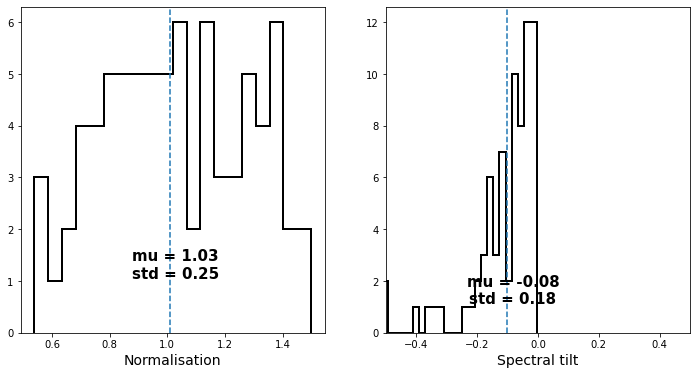

In [27]:
plt.figure(figsize=(12,6))

ax1 = plt.subplot(121)
ax1.hist(norm, density=False, histtype='step', bins=20, linewidth=2, color = "green", ec="black")
median = np.median(norm)
std = np.std(norm)
ax1.axvline(x=median-0.02, ymin=0, ymax=10, linestyle='dashed')
ax1.text(median, 1, f"mu = {median:.2f}\nstd = {std:.2f}", horizontalalignment='center',
     verticalalignment='bottom', fontweight = "bold", fontsize=15)
ax1.set_xlabel('Normalisation', fontsize=label_fontsize)
#plt.xlim(0.5, 1.5)

ax2 = plt.subplot(122)
ax2.hist(tilt, density=False, histtype='step', bins=40, linewidth=2, color = "green", ec="black")
median = np.median(tilt)
std = np.std(tilt)
ax2.axvline(x=median-0.02, ymin=0, ymax=10, linestyle='dashed')
ax2.text(median, 1, f"mu = {median:.2f}\nstd = {std:.2f}", horizontalalignment='center',
     verticalalignment='bottom', fontweight = "bold", fontsize=15)
ax2.set_xlabel('Spectral tilt', fontsize=label_fontsize)
ax2.set_xlim(-0.5, 0.5)

plt.savefig(os.path.join(plot_dir,'norms_distribution_iter1.png'), dpi=dpi, bbox_inches='tight')

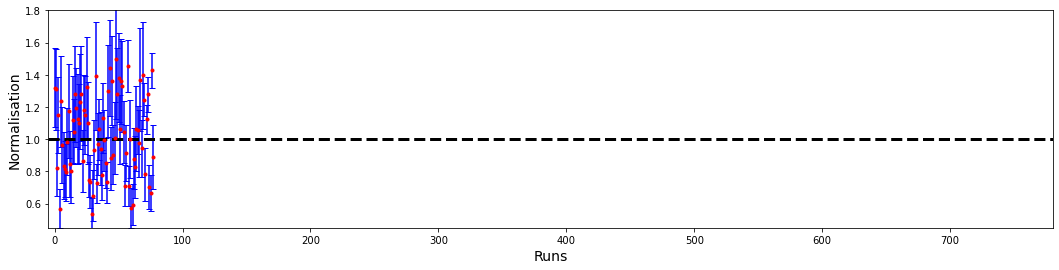

In [28]:
fig = plt.figure(figsize=(18,4))
fig.tight_layout()

#linestyle = '-'
index = list(range(0, len(norm)))
np_index = np.array(index)
#plt.errorbar(np_index, norm, ms=4*markersize, fmt='blue', linewidth=2.0, capsize=5)


plt.errorbar(np_index, norm, norm_err, 
            ms=1, linewidth=1.5, capsize=3, fmt='o', color='blue')

plt.errorbar(np_index, norm,
             ms=3, fmt='o', color='red')

plt.axhline(y = 1, color ="black", linestyle ="--", linewidth=3)

plt.xlabel('Runs', fontsize=14)
plt.ylabel('Normalisation', fontsize=14)
plt.xlim(-5, 780)
plt.ylim(0.45, 1.8)

plt.savefig(os.path.join(plot_dir,'norms_iter1.png'), dpi=dpi, bbox_inches='tight')

 ## Save into disk

In [29]:
path = Path("dataset")
path.mkdir(exist_ok=True)

filename = path / "reduced_dataset_iter1.fits.gz"
stacked_iter1.write(filename, overwrite=True)

### Read MapDataset from the disk

In [30]:
path = Path("dataset")
filename = path / "reduced_dataset_iter1.fits.gz"
stacked_iter1 = MapDataset.read(filename, name='stacked')
print(stacked_iter1)

MapDataset
----------

  Name                            : stacked 

  Total counts                    : 33909 
  Total background counts         : 31025.15
  Total excess counts             : 2883.85

  Predicted counts                : 31025.15
  Predicted background counts     : 31025.15
  Predicted excess counts         : nan

  Exposure min                    : 4.92e-03 m2 s
  Exposure max                    : 6.22e+10 m2 s

  Number of total bins            : 1440000 
  Number of fit bins              : 1035248 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




### Checking on/off histograms

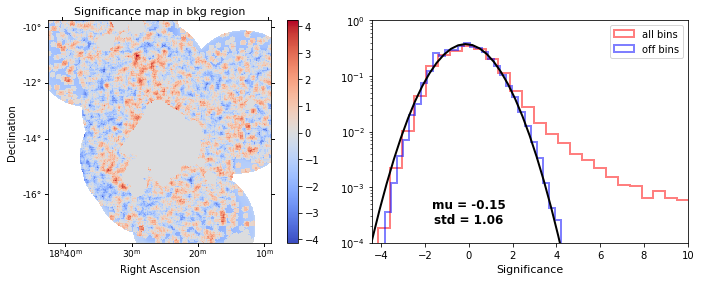

In [31]:
estimator = ExcessMapEstimator(
    correlation_radius=0.1 * u.deg,
    energy_edges=[Elow, Ehigh]*u.TeV, 
    selection_optional=None)

lima_maps_iter1 = estimator.run(stacked_iter1)

significance_map_iter1 = lima_maps_iter1["sqrt_ts"]
sqrt_ts_image_iter1 = significance_map_iter1.get_image_by_idx((0,))

mask_image = mask_map.sum_over_axes()
mask_image.data = mask_image.data.astype(bool)

significance_map_off = significance_map_iter1 * mask_image
significance_all = significance_map_iter1.data[np.isfinite(significance_map_iter1.data)]
significance_off = significance_map_off.data[
    np.isfinite(significance_map_off.data)]
significance_off= significance_off[significance_off != 0]


fig = plt.figure(figsize=(12,9))
fig.tight_layout()


gaus_width = "0.02 deg"
lw = 1.2

#### Significance map ####
ax1 = plt.subplot(221, projection=sqrt_ts_image_iter1.geom.wcs)
significance_map_off.plot(ax=ax1, add_cbar=True, cmap='coolwarm')
ax1.tick_params(axis='both', which='major', labelsize=9)
ax1.set_xlabel('Right Ascension', fontsize=10)
ax1.set_ylabel('Declination', fontsize=10)
ax1.set_title('Significance map in bkg region', fontsize=11)


#### off distribution ###
ax2 = plt.subplot(222)
plt.hist(
    significance_all,
    density=True,
    alpha=0.5,
    color="red",
    label="all bins",
    bins=30,
    histtype='step',
    linewidth=2
)

plt.hist(
    significance_off,
    density=True,
    alpha=0.5,
    color="blue",
    label="off bins",
    bins=30,
    histtype='step',
    linewidth=2
)

# Now, fit the off distribution with a Gaussian
from scipy.stats import norm
mu, std = norm.fit(significance_off)
x = np.linspace(-8, 8, 50)
p = norm.pdf(x, mu, std)
plt.plot(x, p, lw=2, color="black")
ax2.legend()
ax2.set_xlabel('Significance', fontsize=11)
plt.yscale("log")
xmin, xmax = np.min(significance_all), np.max(significance_all)
ax2.set_xlim(xmin-0.3, 10)
ax2.set_ylim(1e-4, 1)



#log.write(f"Fit results: mu = {mu:.2f}, std = {std:.2f}\n")
#print(f"Fit results: mu = {mu:.2f}, std = {std:.2f}")

ax2.text(0, 2e-4, f"mu = {mu:.2f}\nstd = {std:.2f}", horizontalalignment='center',
     verticalalignment='bottom', fontweight = "bold", fontsize=12)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.12, hspace=None)
plt.savefig(os.path.join(plot_dir,'off_excess_and_sign_maps_iter1_01deg.png'), dpi=dpi, bbox_inches='tight')

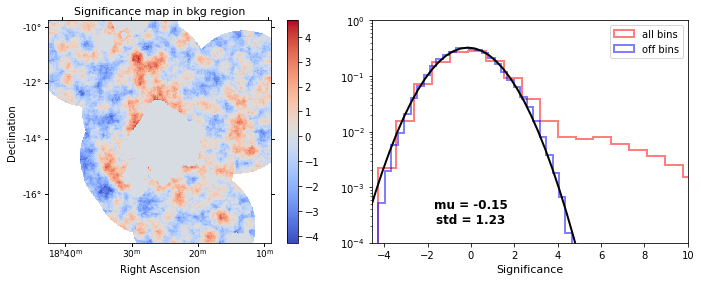

In [32]:
estimator = ExcessMapEstimator(
    correlation_radius=0.22 * u.deg,
    energy_edges=[Elow, Ehigh]*u.TeV, 
    selection_optional=None)

lima_maps_iter1 = estimator.run(stacked_iter1)

significance_map_iter1 = lima_maps_iter1["sqrt_ts"]
sqrt_ts_image_iter1 = significance_map_iter1.get_image_by_idx((0,))

mask_image = mask_map.sum_over_axes()
mask_image.data = mask_image.data.astype(bool)

significance_map_off = significance_map_iter1 * mask_image
significance_all = significance_map_iter1.data[np.isfinite(significance_map_iter1.data)]
significance_off = significance_map_off.data[
    np.isfinite(significance_map_off.data)]
significance_off= significance_off[significance_off != 0]


fig = plt.figure(figsize=(12,9))
fig.tight_layout()


gaus_width = "0.02 deg"
lw = 1.2

#### Significance map ####
ax1 = plt.subplot(221, projection=sqrt_ts_image_iter1.geom.wcs)
significance_map_off.plot(ax=ax1, add_cbar=True, cmap='coolwarm')
ax1.tick_params(axis='both', which='major', labelsize=9)
ax1.set_xlabel('Right Ascension', fontsize=10)
ax1.set_ylabel('Declination', fontsize=10)
ax1.set_title('Significance map in bkg region', fontsize=11)


#### off distribution ###
ax2 = plt.subplot(222)
plt.hist(
    significance_all,
    density=True,
    alpha=0.5,
    color="red",
    label="all bins",
    bins=30,
    histtype='step',
    linewidth=2
)

plt.hist(
    significance_off,
    density=True,
    alpha=0.5,
    color="blue",
    label="off bins",
    bins=30,
    histtype='step',
    linewidth=2
)

# Now, fit the off distribution with a Gaussian
from scipy.stats import norm
mu, std = norm.fit(significance_off)
x = np.linspace(-8, 8, 50)
p = norm.pdf(x, mu, std)
plt.plot(x, p, lw=2, color="black")
ax2.legend()
ax2.set_xlabel('Significance', fontsize=11)
plt.yscale("log")
xmin, xmax = np.min(significance_all), np.max(significance_all)
ax2.set_xlim(xmin-0.3, 10)
ax2.set_ylim(1e-4, 1)



#log.write(f"Fit results: mu = {mu:.2f}, std = {std:.2f}\n")
#print(f"Fit results: mu = {mu:.2f}, std = {std:.2f}")

ax2.text(0, 2e-4, f"mu = {mu:.2f}\nstd = {std:.2f}", horizontalalignment='center',
     verticalalignment='bottom', fontweight = "bold", fontsize=12)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.12, hspace=None)
plt.savefig(os.path.join(plot_dir,'off_excess_and_sign_maps_iter1_022deg.png'), dpi=dpi, bbox_inches='tight')

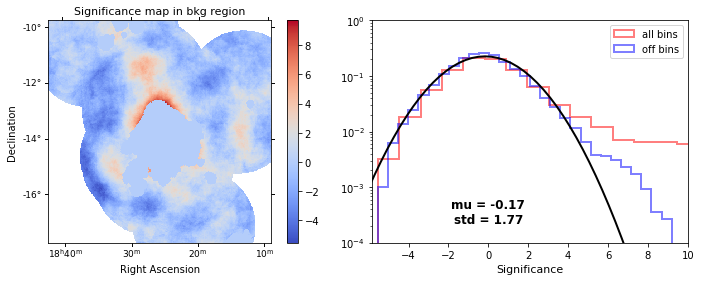

In [33]:
estimator = ExcessMapEstimator(
    correlation_radius=0.5 * u.deg,
    energy_edges=[Elow, Ehigh]*u.TeV, 
    selection_optional=None)

lima_maps_iter1_05 = estimator.run(stacked_iter1)

significance_map_iter1 = lima_maps_iter1_05["sqrt_ts"]
sqrt_ts_image_iter1 = significance_map_iter1.get_image_by_idx((0,))

mask_image = mask_map.sum_over_axes()
mask_image.data = mask_image.data.astype(bool)

significance_map_off = significance_map_iter1 * mask_image
significance_all = significance_map_iter1.data[np.isfinite(significance_map_iter1.data)]
significance_off = significance_map_off.data[
    np.isfinite(significance_map_off.data)]
significance_off= significance_off[significance_off != 0]


fig = plt.figure(figsize=(12,9))
fig.tight_layout()


gaus_width = "0.02 deg"
lw = 1.2

#### Significance map ####
ax1 = plt.subplot(221, projection=sqrt_ts_image_iter1.geom.wcs)
significance_map_off.plot(ax=ax1, add_cbar=True, cmap='coolwarm')
ax1.tick_params(axis='both', which='major', labelsize=9)
ax1.set_xlabel('Right Ascension', fontsize=10)
ax1.set_ylabel('Declination', fontsize=10)
ax1.set_title('Significance map in bkg region', fontsize=11)


#### off distribution ###
ax2 = plt.subplot(222)
plt.hist(
    significance_all,
    density=True,
    alpha=0.5,
    color="red",
    label="all bins",
    bins=30,
    histtype='step',
    linewidth=2
)

plt.hist(
    significance_off,
    density=True,
    alpha=0.5,
    color="blue",
    label="off bins",
    bins=30,
    histtype='step',
    linewidth=2
)

# Now, fit the off distribution with a Gaussian
from scipy.stats import norm
mu, std = norm.fit(significance_off)
x = np.linspace(-8, 8, 50)
p = norm.pdf(x, mu, std)
plt.plot(x, p, lw=2, color="black")
ax2.legend()
ax2.set_xlabel('Significance', fontsize=11)
plt.yscale("log")
xmin, xmax = np.min(significance_all), np.max(significance_all)
ax2.set_xlim(xmin-0.3, 10)
ax2.set_ylim(1e-4, 1)



#log.write(f"Fit results: mu = {mu:.2f}, std = {std:.2f}\n")
#print(f"Fit results: mu = {mu:.2f}, std = {std:.2f}")

ax2.text(0, 2e-4, f"mu = {mu:.2f}\nstd = {std:.2f}", horizontalalignment='center',
     verticalalignment='bottom', fontweight = "bold", fontsize=12)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.12, hspace=None)
plt.savefig(os.path.join(plot_dir,'off_excess_and_sign_maps_iter1_05deg.png'), dpi=dpi, bbox_inches='tight')

# Run the data reduction 2 with an interative mask

Text(0.5, 0, 'Right Ascension')

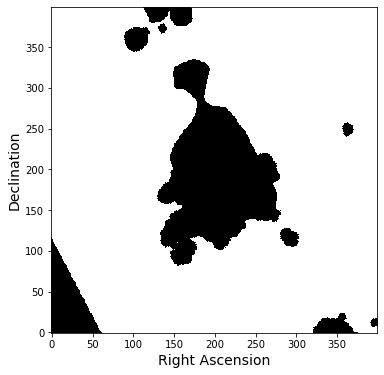

In [34]:
# Enlarge exclusion mask
exclusion_enlarged_iter2 = mask_map.slice_by_idx({"energy" : 0}).copy()
res = lima_maps_iter1_05['sqrt_ts'].sum_over_axes(keepdims=False)
res.data = np.nan_to_num(res.data)
mask_map_significance = res.copy()
mask_map_significance.data = ~apply_hysteresis_threshold(
            mask_map_significance.smooth(width="0.1 deg").data,
            low=Low_Thres,
            high=High_Thres)
exclusion_enlarged_iter2 *= mask_map_significance

#import pickle
#f = open(b"total_mask_map_iter2.txt","wb") # Pickling
#pickle.dump(exclusion_enlarged_iter2, f)
#f.close()

#with open("masks.txt", "rb") as fp:   # Unpickling
#    total_mask_map = pickle.load(fp)


plt.figure(figsize=figsize)
ax=plt.subplot(111)
exclusion_enlarged_iter2.sum_over_axes().plot(ax=ax)
plt.ylabel('Declination', fontsize=label_fontsize)
plt.xlabel('Right Ascension', fontsize=label_fontsize)
#plt.savefig(os.path.join(plot_dir,'exclusion_masks_iter2.png'), dpi=dpi, bbox_inches='tight')

<WCSAxesSubplot:xlabel='Right Ascension', ylabel='Declination'>

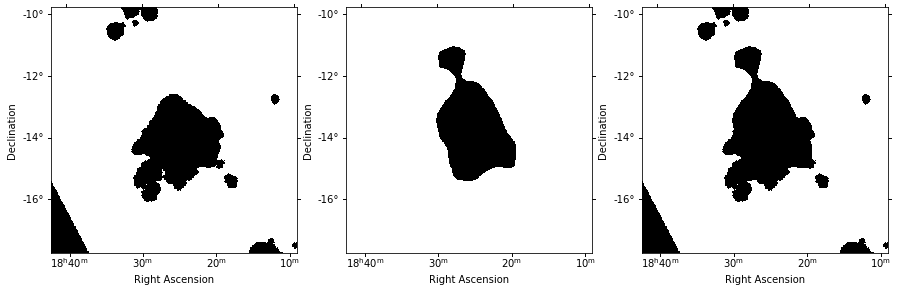

In [35]:
plt.figure(figsize=(15, 5))

wcs = lima_maps_iter1_05['sqrt_ts'].geom.wcs

ax1 = plt.subplot(131, projection=wcs)
mask_map.slice_by_idx({"energy" : 0}).plot(ax=ax1)

ax2 = plt.subplot(132, projection=wcs)
mask_map_significance.plot(ax=ax2)

ax3 = plt.subplot(133, projection=wcs)
exclusion_enlarged_iter2.plot(ax=ax3)

### Define FoVBackgroundMaker with exclusion masks

In [36]:
from gammapy.modeling.models import PowerLawNormSpectralModel
# modify default value on the class level
PowerLawNormSpectralModel.tilt.frozen = False
pwl = PowerLawNormSpectralModel()
print(pwl)
maker_fov = FoVBackgroundMaker(method="fit", exclusion_mask=exclusion_enlarged_iter2)

PowerLawNormSpectralModel

  type      name     value    unit   error   min max frozen link
-------- --------- ---------- ---- --------- --- --- ------ ----
spectral      norm 1.0000e+00      0.000e+00 nan nan  False     
spectral      tilt 0.0000e+00      0.000e+00 nan nan  False     
spectral reference 1.0000e+00  TeV 0.000e+00 nan nan   True     


### Run the data reduction

In [37]:
path = Path(plot_dir)
path.mkdir(exist_ok=True)

bkg_norms_iter2 = open(path /  f"bkg_norms_iter2.txt", 'w')
prb_runs_iter2 = open(path /  f"prb_runs_iter2.txt", 'w')

In [38]:
%%time

for obs in observations:
    try:
     # First a cutout of the target map is produced
       cutout = stacked_iter2.cutout(
       obs.pointing_radec, width=2 * offset_max, name=f"obs-{obs.obs_id}", mode="partial") 
    # A MapDataset is filled in this cutout geometry
       dataset_iter2 = maker.run(cutout, obs)
    # The data quality cut is applied
       dataset_iter2 = maker_safe_mask.run(dataset_iter2, obs)
    # fit background model
       dataset_iter2 = maker_fov.run(dataset_iter2)
       norm = dataset_iter2.models[0].spectral_model.norm.value
       norm_err = dataset_iter2.models[0].spectral_model.norm.error
       tilt = dataset_iter2.models[0].spectral_model.tilt.value
       tilt_err = dataset_iter2.models[0].spectral_model.tilt.error
       #print(
       # f"Background norm obs {obs.obs_id}: {dataset_iter1.background_model.parameters['norm'].value:.2f}")
    #if the background norm is completely off scale don't stack run
       if np.abs(norm-1.)>0.5:
           print(f"Dropping run - Bad norm (n={norm}).")
           continue
       if norm_err/norm>0.25:
           print(f"Dropping run - Large error on norm (n_err/n={norm_err/norm}).")
           continue
       if np.abs(tilt_err/tilt)>0.2:
          print("Dropping run - Large error on tilt (err_t/t={tilt_err/tilt}.")
          continue
       bkg_norms_iter2.write(f"{norm} \t {norm_err} \t {tilt}\n") 
       #print(dataset_iter1.background_model.parameters["norm"].value, dataset_iter1.background_model.parameters["tilt"].value)
     # The resulting dataset cutout is stacked onto the final one
       stacked_iter2.stack(dataset_iter2)
    except:
        prb_runs_iter2.write(f"Error with {obs.obs_id}\n")
        print(f"Error with {obs.obs_id}")
        pass
  
bkg_norms_iter2.close()
prb_runs_iter2.close()

Dropping run - Large error on norm (n_err/n=0.6759766142715846).
Dropping run - Bad norm (n=2.109871426183052).
Dropping run - Bad norm (n=2.9176376663744783).
Dropping run - Bad norm (n=1.6358982165842826).
Dropping run - Bad norm (n=1.8717557832991647).
Dropping run - Bad norm (n=1.5195314556009845).
Dropping run - Bad norm (n=1.854349864396009).
Dropping run - Bad norm (n=1.723994273422807).
Dropping run - Bad norm (n=2.749519984956249).
Dropping run - Bad norm (n=1.5029721836428271).
Dropping run - Bad norm (n=1.7261396067815027).
Dropping run - Bad norm (n=1.552077410063927).
Dropping run - Large error on tilt (err_t/t={tilt_err/tilt}.
Dropping run - Large error on norm (n_err/n=0.3140003705515961).
Dropping run - Bad norm (n=1.896001342266748).
Dropping run - Bad norm (n=1.6785951004812416).
Dropping run - Bad norm (n=1.9485974493757183).
Dropping run - Bad norm (n=3.139314974145813).
Dropping run - Bad norm (n=1.645324724651548).
Dropping run - Bad norm (n=1.6057496480530753).
D

FoVBackgroundMaker failed. Fit did not converge for obs-22473. Setting mask to False.


Dropping run - Bad norm (n=324320.371442219).
Dropping run - Bad norm (n=2.28431956903101).
Dropping run - Large error on norm (n_err/n=0.539643256423088).
Dropping run - Large error on norm (n_err/n=0.8522321982716963).
Dropping run - Large error on norm (n_err/n=0.32028436980993313).
Dropping run - Bad norm (n=0.4898021849520599).
Dropping run - Bad norm (n=0.4176994080644112).
Dropping run - Large error on norm (n_err/n=0.3814607482726729).
Dropping run - Bad norm (n=1.6015276161653424).
Dropping run - Large error on norm (n_err/n=0.3709657750579453).
Dropping run - Large error on tilt (err_t/t={tilt_err/tilt}.
Dropping run - Large error on norm (n_err/n=0.4316591810190678).
Dropping run - Bad norm (n=0.45918411292921374).
Dropping run - Large error on tilt (err_t/t={tilt_err/tilt}.
Dropping run - Bad norm (n=2.0022695301527698).
Dropping run - Bad norm (n=1.7125335139254458).
Dropping run - Bad norm (n=1.9706920251406297).
Dropping run - Bad norm (n=1.8372460700565894).
Dropping ru

In [39]:
load_textdata = np.loadtxt(path / 'bkg_norms_iter2.txt')
norm, norm_err,  tilt = np.transpose(load_textdata)

#normal_norms = []
#for norm in list(range(len(norms))):
#    if norms[norm]>0.5 and norms[norm]<1.5:
#        normal_norms.append(norms[norm])

#run_list.close()

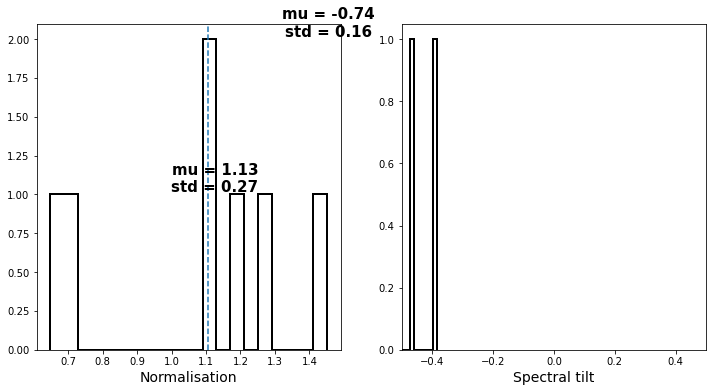

In [40]:
plt.figure(figsize=(12,6))

ax1 = plt.subplot(121)
ax1.hist(norm, density=False, histtype='step', bins=20, linewidth=2, color = "green", ec="black")
median = np.median(norm)
std = np.std(norm)
ax1.axvline(x=median-0.02, ymin=0, ymax=10, linestyle='dashed')
ax1.text(median, 1, f"mu = {median:.2f}\nstd = {std:.2f}", horizontalalignment='center',
     verticalalignment='bottom', fontweight = "bold", fontsize=15)
ax1.set_xlabel('Normalisation', fontsize=label_fontsize)
#plt.xlim(0.5, 1.5)

ax2 = plt.subplot(122)
ax2.hist(tilt, density=False, histtype='step', bins=40, linewidth=2, color = "green", ec="black")
median = np.median(tilt)
std = np.std(tilt)
ax2.axvline(x=median-0.02, ymin=0, ymax=10, linestyle='dashed')
ax2.text(median, 1, f"mu = {median:.2f}\nstd = {std:.2f}", horizontalalignment='center',
     verticalalignment='bottom', fontweight = "bold", fontsize=15)
ax2.set_xlabel('Spectral tilt', fontsize=label_fontsize)
ax2.set_xlim(-0.5, 0.5)

plt.savefig(os.path.join(plot_dir,'norms_distribution_iter2.png'), dpi=dpi, bbox_inches='tight')

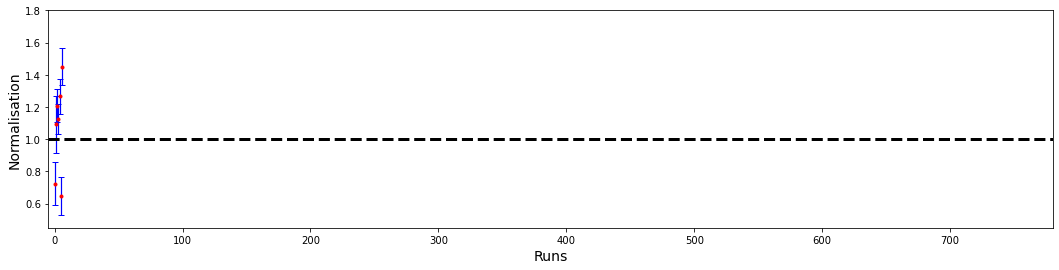

In [41]:
fig = plt.figure(figsize=(18,4))
fig.tight_layout()

#linestyle = '-'
index = list(range(0, len(norm)))
np_index = np.array(index)
#plt.errorbar(np_index, norm, ms=4*markersize, fmt='blue', linewidth=2.0, capsize=5)


plt.errorbar(np_index, norm, norm_err, 
            ms=1, linewidth=1.2, capsize=3, fmt='o', color='blue')

plt.errorbar(np_index, norm,
             ms=3, fmt='o', color='red')

plt.axhline(y = 1, color ="black", linestyle ="--", linewidth=3)

plt.xlabel('Runs', fontsize=14)
plt.ylabel('Normalisation', fontsize=14)
plt.xlim(-5, 780)
plt.ylim(0.45, 1.8)

plt.savefig(os.path.join(plot_dir,'norms_iter2.png'), dpi=dpi, bbox_inches='tight')

### Save into disk

In [42]:
path = Path("dataset")
path.mkdir(exist_ok=True)

filename = path / "reduced_dataset_iter2.fits.gz"
stacked_iter2.write(filename, overwrite=True)

### Read MapDataset from the disk

In [43]:
path = Path("dataset")
filename = path / "reduced_dataset_iter2.fits.gz"
stacked_iter2 = MapDataset.read(filename, name='stacked')
print(stacked_iter2)

MapDataset
----------

  Name                            : stacked 

  Total counts                    : 10658 
  Total background counts         : 10035.79
  Total excess counts             : 622.21

  Predicted counts                : 10035.79
  Predicted background counts     : 10035.79
  Predicted excess counts         : nan

  Exposure min                    : 1.49e-04 m2 s
  Exposure max                    : 5.82e+09 m2 s

  Number of total bins            : 1440000 
  Number of fit bins              : 546512 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




### Checking on/off histograms

Fit results: mu = -0.10, std = 1.12


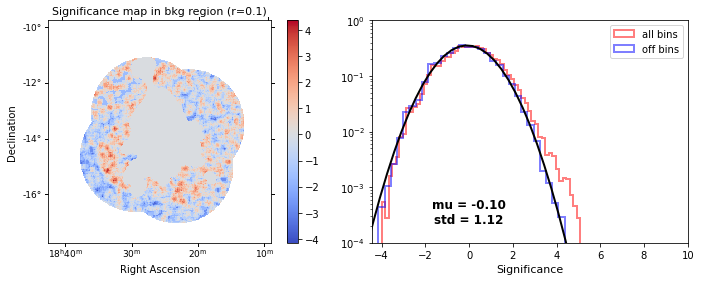

In [44]:
estimator = ExcessMapEstimator(
    correlation_radius=0.1 * u.deg,
    energy_edges=[Elow, Ehigh]*u.TeV, 
    selection_optional=None)
lima_maps_iter2 = estimator.run(stacked_iter2)

significance_map_iter2 = lima_maps_iter2["sqrt_ts"]
sqrt_ts_image_iter2 = significance_map_iter2.get_image_by_idx((0,))


mask_image = exclusion_enlarged_iter2.interp_to_geom(significance_map_iter2.geom).sum_over_axes()
mask_image.data = mask_image.data.astype(bool)
significance_map_off = significance_map_iter2 * mask_image

significance_all = significance_map_iter2.data[np.isfinite(significance_map_iter2.data)]
significance_off = significance_map_off.data[
    np.isfinite(significance_map_off.data)]
significance_off= significance_off[significance_off != 0]


fig = plt.figure(figsize=(12,9))
fig.tight_layout()


gaus_width = "0.02 deg"
lw = 1.2

#### Significance map #### cmap="coolwarm"
ax1 = plt.subplot(221, projection=sqrt_ts_image_iter2.geom.wcs)
significance_map_off.plot(ax=ax1, add_cbar=True, cmap="coolwarm")

# Define labels
label_markersize, fontsize  = 6,6
#legend_elements = [Line2D([0], [0], marker="o", color='none', label='Masks around HGPS sources',
#                          markeredgecolor='blue', markersize=label_markersize)]
#ax1.legend(handles=legend_elements, fancybox=True, 
#           framealpha=1.0, loc = 'upper left', fontsize=fontsize, edgecolor='black')

ax1.tick_params(axis='both', which='major', labelsize=9)
ax1.set_xlabel('Right Ascension', fontsize=10)
ax1.set_ylabel('Declination', fontsize=10)
ax1.set_title('Significance map in bkg region (r=0.1)', fontsize=11)


#### off distribution ###
ax2 = plt.subplot(222)
plt.hist(
    significance_all,
    density=True,
    alpha=0.5,
    color="red",
    label="all bins",
    bins=60,
    histtype='step',
    linewidth=2
)

plt.hist(
    significance_off,
    density=True,
    alpha=0.5,
    color="blue",
    label="off bins",
    bins=30,
    histtype='step',
    linewidth=2
)

# Now, fit the off distribution with a Gaussian
from scipy.stats import norm
mu, std = norm.fit(significance_off)
x = np.linspace(-8, 8, 50)
p = norm.pdf(x, mu, std)
plt.plot(x, p, lw=2, color="black")
ax2.legend()
ax2.set_xlabel('Significance', fontsize=11)
plt.yscale("log")
plt.ylim(1e-4, 1)
xmin, xmax = np.min(significance_all), np.max(significance_all)
plt.xlim(xmin-0.3, 10)

#log.write(f"Fit results: mu = {mu:.2f}, std = {std:.2f}\n")
print(f"Fit results: mu = {mu:.2f}, std = {std:.2f}")

ax2.text(0, 2e-4, f"mu = {mu:.2f}\nstd = {std:.2f}", horizontalalignment='center',
     verticalalignment='bottom', fontweight = "bold", fontsize=12)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.12, hspace=None)
plt.savefig(os.path.join(plot_dir,'off_excess_and_sign_maps_iter2_01deg.png'), dpi=dpi, bbox_inches='tight')


### Checking on/off histograms

Fit results: mu = -0.07, std = 1.45


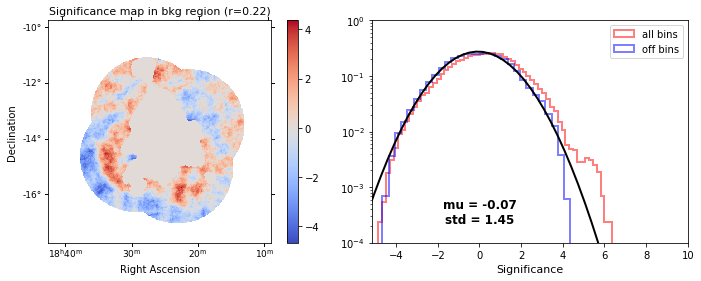

In [45]:
estimator = ExcessMapEstimator(
    correlation_radius=0.22 * u.deg,
    energy_edges=[Elow, Ehigh]*u.TeV, 
    selection_optional=None)
lima_maps_iter2 = estimator.run(stacked_iter2)

significance_map_iter2 = lima_maps_iter2["sqrt_ts"]
sqrt_ts_image_iter2 = significance_map_iter2.get_image_by_idx((0,))


mask_image = exclusion_enlarged_iter2.interp_to_geom(significance_map_iter2.geom).sum_over_axes()
mask_image.data = mask_image.data.astype(bool)
significance_map_off = significance_map_iter2 * mask_image

significance_all = significance_map_iter2.data[np.isfinite(significance_map_iter2.data)]
significance_off = significance_map_off.data[
    np.isfinite(significance_map_off.data)]
significance_off= significance_off[significance_off != 0]


fig = plt.figure(figsize=(12,9))
fig.tight_layout()


gaus_width = "0.02 deg"
lw = 1.2

#### Significance map #### cmap="coolwarm"
ax1 = plt.subplot(221, projection=sqrt_ts_image_iter2.geom.wcs)
significance_map_off.plot(ax=ax1, add_cbar=True, cmap="coolwarm")

# Define labels
label_markersize, fontsize  = 6,6
#legend_elements = [Line2D([0], [0], marker="o", color='none', label='Masks around HGPS sources',
#                          markeredgecolor='blue', markersize=label_markersize)]
#ax1.legend(handles=legend_elements, fancybox=True, 
#           framealpha=1.0, loc = 'upper left', fontsize=fontsize, edgecolor='black')

ax1.tick_params(axis='both', which='major', labelsize=9)
ax1.set_xlabel('Right Ascension', fontsize=10)
ax1.set_ylabel('Declination', fontsize=10)
ax1.set_title('Significance map in bkg region (r=0.22)', fontsize=11)


#### off distribution ###
ax2 = plt.subplot(222)
plt.hist(
    significance_all,
    density=True,
    alpha=0.5,
    color="red",
    label="all bins",
    bins=60,
    histtype='step',
    linewidth=2
)

plt.hist(
    significance_off,
    density=True,
    alpha=0.5,
    color="blue",
    label="off bins",
    bins=30,
    histtype='step',
    linewidth=2
)

# Now, fit the off distribution with a Gaussian
from scipy.stats import norm
mu, std = norm.fit(significance_off)
x = np.linspace(-8, 8, 50)
p = norm.pdf(x, mu, std)
plt.plot(x, p, lw=2, color="black")
ax2.legend()
ax2.set_xlabel('Significance', fontsize=11)
plt.yscale("log")
plt.ylim(1e-4, 1)
xmin, xmax = np.min(significance_all), np.max(significance_all)
plt.xlim(xmin-0.3, 10)

#log.write(f"Fit results: mu = {mu:.2f}, std = {std:.2f}\n")
print(f"Fit results: mu = {mu:.2f}, std = {std:.2f}")

ax2.text(0, 2e-4, f"mu = {mu:.2f}\nstd = {std:.2f}", horizontalalignment='center',
     verticalalignment='bottom', fontweight = "bold", fontsize=12)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.12, hspace=None)
plt.savefig(os.path.join(plot_dir,'off_excess_and_sign_maps_iter2_22deg.png'), dpi=dpi, bbox_inches='tight')

Fit results: mu = -0.02, std = 2.12


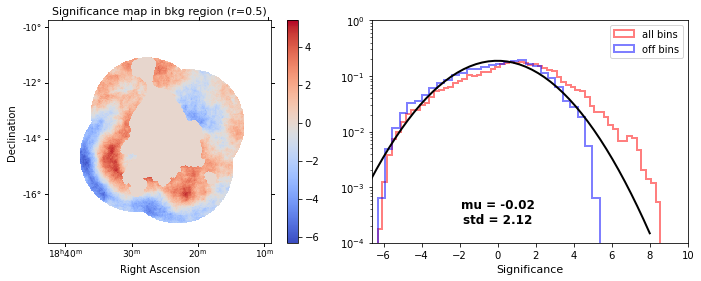

In [46]:
estimator = ExcessMapEstimator(
    correlation_radius=0.5 * u.deg,
    energy_edges=[Elow, Ehigh]*u.TeV, 
    selection_optional=None)
lima_maps_iter2_05 = estimator.run(stacked_iter2)

significance_map_iter2 = lima_maps_iter2_05["sqrt_ts"]
sqrt_ts_image_iter2 = significance_map_iter2.get_image_by_idx((0,))


mask_image = exclusion_enlarged_iter2.interp_to_geom(significance_map_iter2.geom).sum_over_axes()
mask_image.data = mask_image.data.astype(bool)
significance_map_off = significance_map_iter2 * mask_image

significance_all = significance_map_iter2.data[np.isfinite(significance_map_iter2.data)]
significance_off = significance_map_off.data[
    np.isfinite(significance_map_off.data)]
significance_off= significance_off[significance_off != 0]


fig = plt.figure(figsize=(12,9))
fig.tight_layout()


gaus_width = "0.02 deg"
lw = 1.2

#### Significance map #### cmap="coolwarm"
ax1 = plt.subplot(221, projection=sqrt_ts_image_iter2.geom.wcs)
significance_map_off.plot(ax=ax1, add_cbar=True, cmap="coolwarm")

# Define labels
label_markersize, fontsize  = 6,6
#legend_elements = [Line2D([0], [0], marker="o", color='none', label='Masks around HGPS sources',
#                          markeredgecolor='blue', markersize=label_markersize)]
#ax1.legend(handles=legend_elements, fancybox=True, 
#           framealpha=1.0, loc = 'upper left', fontsize=fontsize, edgecolor='black')

ax1.tick_params(axis='both', which='major', labelsize=9)
ax1.set_xlabel('Right Ascension', fontsize=10)
ax1.set_ylabel('Declination', fontsize=10)
ax1.set_title('Significance map in bkg region (r=0.5)', fontsize=11)


#### off distribution ###
ax2 = plt.subplot(222)
plt.hist(
    significance_all,
    density=True,
    alpha=0.5,
    color="red",
    label="all bins",
    bins=60,
    histtype='step',
    linewidth=2
)

plt.hist(
    significance_off,
    density=True,
    alpha=0.5,
    color="blue",
    label="off bins",
    bins=30,
    histtype='step',
    linewidth=2
)

# Now, fit the off distribution with a Gaussian
from scipy.stats import norm
mu, std = norm.fit(significance_off)
x = np.linspace(-8, 8, 50)
p = norm.pdf(x, mu, std)
plt.plot(x, p, lw=2, color="black")
ax2.legend()
ax2.set_xlabel('Significance', fontsize=11)
plt.yscale("log")
plt.ylim(1e-4, 1)
xmin, xmax = np.min(significance_all), np.max(significance_all)
plt.xlim(xmin-0.3, 10)

#log.write(f"Fit results: mu = {mu:.2f}, std = {std:.2f}\n")
print(f"Fit results: mu = {mu:.2f}, std = {std:.2f}")

ax2.text(0, 2e-4, f"mu = {mu:.2f}\nstd = {std:.2f}", horizontalalignment='center',
     verticalalignment='bottom', fontweight = "bold", fontsize=12)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.12, hspace=None)
plt.savefig(os.path.join(plot_dir,'off_excess_and_sign_maps_iter2_05deg.png'), dpi=dpi, bbox_inches='tight')

# Run the data reduction 3 with an interactive mask

Text(0.5, 0, 'Right Ascension')

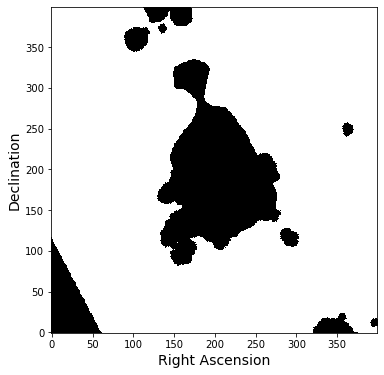

In [47]:
# Enlarge exclusion mask
exclusion_enlarged_iter3 = exclusion_enlarged_iter2.slice_by_idx({"energy" : 0}).copy()
res = lima_maps_iter2_05['sqrt_ts'].sum_over_axes(keepdims=False)
res.data = np.nan_to_num(res.data)
mask_map_significance = res.copy()
mask_map_significance.data = ~apply_hysteresis_threshold(
            mask_map_significance.smooth(width="0.4 deg").data,
            low=Low_Thres,
            high=High_Thres)
exclusion_enlarged_iter3 *= mask_map_significance

#import pickle
#f = open(b"total_mask_map_iter2.txt","wb") # Pickling
#pickle.dump(exclusion_enlarged_iter2, f)
#f.close()

#with open("masks.txt", "rb") as fp:   # Unpickling
#    total_mask_map = pickle.load(fp)


plt.figure(figsize=figsize)
ax=plt.subplot(111)
exclusion_enlarged_iter3.sum_over_axes().plot(ax=ax)
plt.ylabel('Declination', fontsize=label_fontsize)
plt.xlabel('Right Ascension', fontsize=label_fontsize)
#plt.savefig(os.path.join(plot_dir,'exclusion_masks_iter3.png'), dpi=dpi, bbox_inches='tight')

<WCSAxesSubplot:xlabel='Right Ascension', ylabel='Declination'>

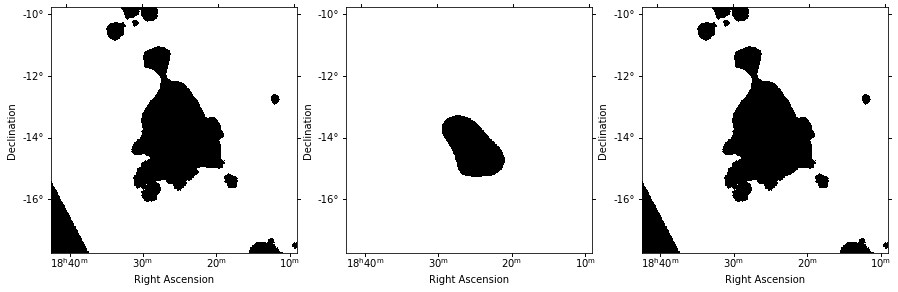

In [48]:
plt.figure(figsize=(15, 5))

wcs = lima_maps_iter2_05['sqrt_ts'].geom.wcs

ax1 = plt.subplot(131, projection=wcs)
exclusion_enlarged_iter2.slice_by_idx({"energy" : 0}).plot(ax=ax1)

ax2 = plt.subplot(132, projection=wcs)
mask_map_significance.plot(ax=ax2)

ax3 = plt.subplot(133, projection=wcs)
exclusion_enlarged_iter3.plot(ax=ax3)

### Define FoVBackgroundMaker with exclusion masks

In [49]:
from gammapy.modeling.models import PowerLawNormSpectralModel
# modify default value on the class level
PowerLawNormSpectralModel.tilt.frozen = False
pwl = PowerLawNormSpectralModel()
print(pwl)
maker_fov = FoVBackgroundMaker(method="fit", exclusion_mask=exclusion_enlarged_iter3)

PowerLawNormSpectralModel

  type      name     value    unit   error   min max frozen link
-------- --------- ---------- ---- --------- --- --- ------ ----
spectral      norm 1.0000e+00      0.000e+00 nan nan  False     
spectral      tilt 0.0000e+00      0.000e+00 nan nan  False     
spectral reference 1.0000e+00  TeV 0.000e+00 nan nan   True     


### Run the data reduction

In [50]:
path = Path(plot_dir)
path.mkdir(exist_ok=True)

bkg_norms_iter3 = open(path /  f"bkg_norms_iter3.txt", 'w')
prb_runs_iter3 = open(path /  f"prb_runs_iter3.txt", 'w')

In [51]:
%%time

for obs in observations:
    try:
     # First a cutout of the target map is produced
       cutout = stacked_iter3.cutout(
       obs.pointing_radec, width=2 * offset_max, name=f"obs-{obs.obs_id}", mode="partial") 
    # A MapDataset is filled in this cutout geometry
       dataset_iter3 = maker.run(cutout, obs)
    # The data quality cut is applied
       dataset_iter3 = maker_safe_mask.run(dataset_iter3, obs)
    # fit background model
       dataset_iter3 = maker_fov.run(dataset_iter3)
       norm = dataset_iter3.models[0].spectral_model.norm.value
       norm_err = dataset_iter3.models[0].spectral_model.norm.error
       tilt = dataset_iter3.models[0].spectral_model.tilt.value
       tilt_err = dataset_iter3.models[0].spectral_model.tilt.error
       #print(
       # f"Background norm obs {obs.obs_id}: {dataset_iter1.background_model.parameters['norm'].value:.2f}")
    #if the background norm is completely off scale don't stack run
       if np.abs(norm-1.)>0.5:
           print(f"Dropping run - Bad norm(n={norm}).")
           continue
       if norm_err/norm>0.25:
           print(f"Dropping run - Large error on norm(n_err/n={norm_err/norm}).")
           continue
       if np.abs(tilt_err/tilt)>0.2:
          print("Dropping run - Large error on tilt (err_t/t={tilt_err/tilt}.")
          continue
       #if np.abs(tilt)>0.5:
       #   print("Dropping run - Bad tilt.")
       #    continue
       bkg_norms_iter3.write(f"{norm} \t {norm_err} \t {tilt}\n") 
       #print(dataset_iter1.background_model.parameters["norm"].value, dataset_iter1.background_model.parameters["tilt"].value)
     # The resulting dataset cutout is stacked onto the final one
       stacked_iter3.stack(dataset_iter3)
    except:
        prb_runs_iter3.write(f"Error with {obs.obs_id}\n")
        print(f"Error with {obs.obs_id}")
        pass
  
bkg_norms_iter3.close()
prb_runs_iter3.close()

Dropping run - Large error on norm(n_err/n=0.6759766142715846).
Dropping run - Bad norm(n=2.109871426183052).
Dropping run - Bad norm(n=2.9176376663744783).
Dropping run - Bad norm(n=1.6358982165842826).
Dropping run - Bad norm(n=1.8717557832991647).
Dropping run - Bad norm(n=1.5195314556009845).
Dropping run - Bad norm(n=1.854349864396009).
Dropping run - Bad norm(n=1.723994273422807).
Dropping run - Bad norm(n=2.706767788884623).
Dropping run - Large error on tilt (err_t/t={tilt_err/tilt}.
Dropping run - Bad norm(n=1.736487837220057).
Dropping run - Bad norm(n=1.537872489128262).
Dropping run - Large error on tilt (err_t/t={tilt_err/tilt}.
Dropping run - Large error on norm(n_err/n=0.3140003705515961).
Dropping run - Bad norm(n=1.896001342266748).
Dropping run - Bad norm(n=1.6785951004812416).
Dropping run - Bad norm(n=1.968253806664326).
Dropping run - Bad norm(n=2.992339050893107).
Dropping run - Bad norm(n=1.6673677072828474).
Dropping run - Bad norm(n=1.6057496480530753).
Droppin

FoVBackgroundMaker failed. Fit did not converge for obs-22473. Setting mask to False.


Dropping run - Bad norm(n=324320.371442219).
Dropping run - Bad norm(n=2.28431956903101).
Dropping run - Large error on norm(n_err/n=0.539643256423088).
Dropping run - Large error on norm(n_err/n=0.8522321982716963).
Dropping run - Large error on norm(n_err/n=0.32028436980993313).
Dropping run - Bad norm(n=0.4898021849520599).
Dropping run - Bad norm(n=0.4176994080644112).
Dropping run - Large error on norm(n_err/n=0.3814607482726729).
Dropping run - Bad norm(n=1.6019587284973575).
Dropping run - Large error on norm(n_err/n=0.370436454146529).
Dropping run - Large error on tilt (err_t/t={tilt_err/tilt}.
Dropping run - Large error on norm(n_err/n=0.4291659023810646).
Dropping run - Bad norm(n=0.46472936705858614).
Dropping run - Large error on tilt (err_t/t={tilt_err/tilt}.
Dropping run - Bad norm(n=1.9612871350106695).
Dropping run - Bad norm(n=1.6939549252843409).
Dropping run - Bad norm(n=1.9487206373626844).
Dropping run - Bad norm(n=1.7856342053267604).
Dropping run - Large error o

In [52]:
load_textdata = np.loadtxt(path / 'bkg_norms_iter3.txt')
norm, norm_err,  tilt = np.transpose(load_textdata)

#normal_norms = []
#for norm in list(range(len(norms))):
#    if norms[norm]>0.5 and norms[norm]<1.5:
#        normal_norms.append(norms[norm])

#run_list.close()

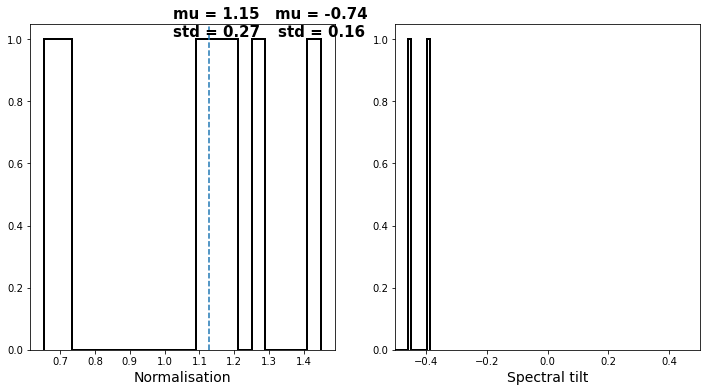

In [53]:
plt.figure(figsize=(12,6))

ax1 = plt.subplot(121)
ax1.hist(norm, density=False, histtype='step', bins=20, linewidth=2, color = "green", ec="black")
median = np.median(norm)
std = np.std(norm)
ax1.axvline(x=median-0.02, ymin=0, ymax=10, linestyle='dashed')
ax1.text(median, 1, f"mu = {median:.2f}\nstd = {std:.2f}", horizontalalignment='center',
     verticalalignment='bottom', fontweight = "bold", fontsize=15)
ax1.set_xlabel('Normalisation', fontsize=label_fontsize)
#plt.xlim(0.5, 1.5)

ax2 = plt.subplot(122)
ax2.hist(tilt, density=False, histtype='step', bins=40, linewidth=2, color = "green", ec="black")
median = np.median(tilt)
std = np.std(tilt)
ax2.axvline(x=median-0.02, ymin=0, ymax=10, linestyle='dashed')
ax2.text(median, 1, f"mu = {median:.2f}\nstd = {std:.2f}", horizontalalignment='center',
     verticalalignment='bottom', fontweight = "bold", fontsize=15)
ax2.set_xlabel('Spectral tilt', fontsize=label_fontsize)
ax2.set_xlim(-0.5, 0.5)

plt.savefig(os.path.join(plot_dir,'norms_distribution_iter3.png'), dpi=dpi, bbox_inches='tight')

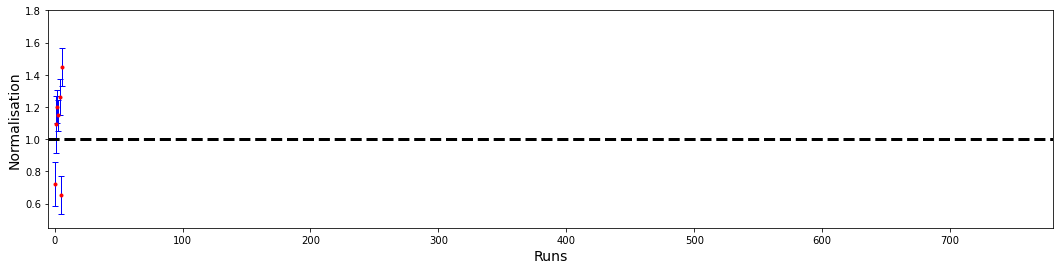

In [54]:
fig = plt.figure(figsize=(18,4))
fig.tight_layout()

#linestyle = '-'
index = list(range(0, len(norm)))
np_index = np.array(index)
#plt.errorbar(np_index, norm, ms=4*markersize, fmt='blue', linewidth=2.0, capsize=5)


plt.errorbar(np_index, norm, norm_err, 
            ms=1, linewidth=1.0, capsize=3, fmt='o', color='blue')

plt.errorbar(np_index, norm,
             ms=3, fmt='o', color='red')

plt.axhline(y = 1, color ="black", linestyle ="--", linewidth=3)

plt.xlabel('Runs', fontsize=14)
plt.ylabel('Normalisation', fontsize=14)
plt.xlim(-5, 780)
plt.ylim(0.45, 1.8)

plt.savefig(os.path.join(plot_dir,'norms_iter3.png'), dpi=dpi, bbox_inches='tight')

### Save into disk

In [55]:
path = Path("dataset")
path.mkdir(exist_ok=True)

filename = path / "reduced_dataset_iter3.fits.gz"
stacked_iter3.write(filename, overwrite=True)

### Read MapDataset from the disk

In [56]:
path = Path("dataset")
filename = path / "reduced_dataset_iter3.fits.gz"
stacked_iter3 = MapDataset.read(filename, name='stacked')
print(stacked_iter3)

MapDataset
----------

  Name                            : stacked 

  Total counts                    : 10658 
  Total background counts         : 10001.14
  Total excess counts             : 656.86

  Predicted counts                : 10001.15
  Predicted background counts     : 10001.14
  Predicted excess counts         : nan

  Exposure min                    : 1.49e-04 m2 s
  Exposure max                    : 5.82e+09 m2 s

  Number of total bins            : 1440000 
  Number of fit bins              : 546512 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




### Checking on/off histograms

Fit results: mu = -0.10, std = 1.12


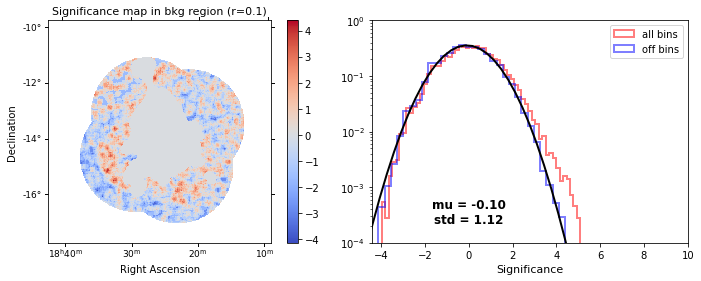

In [57]:
estimator = ExcessMapEstimator(
    correlation_radius=0.1 * u.deg,
    energy_edges=[Elow, Ehigh]*u.TeV, 
    selection_optional=None)
lima_maps_iter3 = estimator.run(stacked_iter3)

significance_map_iter3 = lima_maps_iter3["sqrt_ts"]
sqrt_ts_image_iter3 = significance_map_iter3.get_image_by_idx((0,))

mask_image = exclusion_enlarged_iter3.interp_to_geom(significance_map_iter3.geom).sum_over_axes()
mask_image.data = mask_image.data.astype(bool)
significance_map_off = significance_map_iter3 * mask_image

significance_all = significance_map_iter3.data[np.isfinite(significance_map_iter3.data)]
significance_off = significance_map_off.data[
    np.isfinite(significance_map_off.data)]
significance_off= significance_off[significance_off != 0]


fig = plt.figure(figsize=(12,9))
fig.tight_layout()


gaus_width = "0.02 deg"
lw = 1.2

#### Significance map #### cmap="coolwarm"
ax1 = plt.subplot(221, projection=sqrt_ts_image_iter3.geom.wcs)
significance_map_off.plot(ax=ax1, add_cbar=True, cmap="coolwarm")

# Define labels
label_markersize, fontsize  = 6,6
#legend_elements = [Line2D([0], [0], marker="o", color='none', label='Masks around HGPS sources',
#                          markeredgecolor='blue', markersize=label_markersize)]
#ax1.legend(handles=legend_elements, fancybox=True, 
#           framealpha=1.0, loc = 'upper left', fontsize=fontsize, edgecolor='black')

ax1.tick_params(axis='both', which='major', labelsize=9)
ax1.set_xlabel('Right Ascension', fontsize=10)
ax1.set_ylabel('Declination', fontsize=10)
ax1.set_title('Significance map in bkg region (r=0.1)', fontsize=11)


#### off distribution ###
ax2 = plt.subplot(222)
plt.hist(
    significance_all,
    density=True,
    alpha=0.5,
    color="red",
    label="all bins",
    bins=60,
    histtype='step',
    linewidth=2
)

plt.hist(
    significance_off,
    density=True,
    alpha=0.5,
    color="blue",
    label="off bins",
    bins=30,
    histtype='step',
    linewidth=2
)

# Now, fit the off distribution with a Gaussian
from scipy.stats import norm
mu, std = norm.fit(significance_off)
x = np.linspace(-8, 8, 50)
p = norm.pdf(x, mu, std)
plt.plot(x, p, lw=2, color="black")
ax2.legend()
ax2.set_xlabel('Significance', fontsize=11)
plt.yscale("log")
plt.ylim(1e-4, 1)
xmin, xmax = np.min(significance_all), np.max(significance_all)
plt.xlim(xmin-0.3, 10)



#log.write(f"Fit results: mu = {mu:.2f}, std = {std:.2f}\n")
print(f"Fit results: mu = {mu:.2f}, std = {std:.2f}")

ax2.text(0, 2e-4, f"mu = {mu:.2f}\nstd = {std:.2f}", horizontalalignment='center',
     verticalalignment='bottom', fontweight = "bold", fontsize=12)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.12, hspace=None)
plt.savefig(os.path.join(plot_dir,'off_excess_and_sign_maps_iter3_01deg.png'), dpi=dpi, bbox_inches='tight')

Fit results: mu = -0.06, std = 1.45


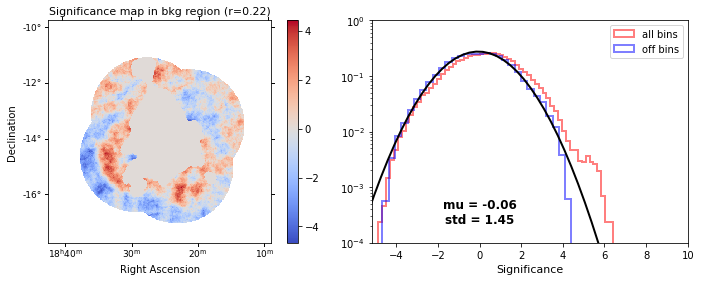

In [58]:
estimator = ExcessMapEstimator(
    correlation_radius=0.22 * u.deg,
    energy_edges=[Elow, Ehigh]*u.TeV, 
    selection_optional=None)
lima_maps_iter3 = estimator.run(stacked_iter3)

significance_map_iter3 = lima_maps_iter3["sqrt_ts"]
sqrt_ts_image_iter3 = significance_map_iter3.get_image_by_idx((0,))

mask_image = exclusion_enlarged_iter3.interp_to_geom(significance_map_iter3.geom).sum_over_axes()
mask_image.data = mask_image.data.astype(bool)
significance_map_off = significance_map_iter3 * mask_image

significance_all = significance_map_iter3.data[np.isfinite(significance_map_iter3.data)]
significance_off = significance_map_off.data[
    np.isfinite(significance_map_off.data)]
significance_off= significance_off[significance_off != 0]


fig = plt.figure(figsize=(12,9))
fig.tight_layout()


gaus_width = "0.02 deg"
lw = 1.2

#### Significance map #### cmap="coolwarm"
ax1 = plt.subplot(221, projection=sqrt_ts_image_iter3.geom.wcs)
significance_map_off.plot(ax=ax1, add_cbar=True, cmap="coolwarm")

# Define labels
label_markersize, fontsize  = 6,6
#legend_elements = [Line2D([0], [0], marker="o", color='none', label='Masks around HGPS sources',
#                          markeredgecolor='blue', markersize=label_markersize)]
#ax1.legend(handles=legend_elements, fancybox=True, 
#           framealpha=1.0, loc = 'upper left', fontsize=fontsize, edgecolor='black')

ax1.tick_params(axis='both', which='major', labelsize=9)
ax1.set_xlabel('Right Ascension', fontsize=10)
ax1.set_ylabel('Declination', fontsize=10)
ax1.set_title('Significance map in bkg region (r=0.22)', fontsize=11)


#### off distribution ###
ax2 = plt.subplot(222)
plt.hist(
    significance_all,
    density=True,
    alpha=0.5,
    color="red",
    label="all bins",
    bins=60,
    histtype='step',
    linewidth=2
)

plt.hist(
    significance_off,
    density=True,
    alpha=0.5,
    color="blue",
    label="off bins",
    bins=30,
    histtype='step',
    linewidth=2
)

# Now, fit the off distribution with a Gaussian
from scipy.stats import norm
mu, std = norm.fit(significance_off)
x = np.linspace(-8, 8, 50)
p = norm.pdf(x, mu, std)
plt.plot(x, p, lw=2, color="black")
ax2.legend()
ax2.set_xlabel('Significance', fontsize=11)
plt.yscale("log")
plt.ylim(1e-4, 1)
xmin, xmax = np.min(significance_all), np.max(significance_all)
plt.xlim(xmin-0.3, 10)



#log.write(f"Fit results: mu = {mu:.2f}, std = {std:.2f}\n")
print(f"Fit results: mu = {mu:.2f}, std = {std:.2f}")

ax2.text(0, 2e-4, f"mu = {mu:.2f}\nstd = {std:.2f}", horizontalalignment='center',
     verticalalignment='bottom', fontweight = "bold", fontsize=12)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.12, hspace=None)
plt.savefig(os.path.join(plot_dir,'off_excess_and_sign_maps_iter3_022deg.png'), dpi=dpi, bbox_inches='tight')

Fit results: mu = 0.01, std = 2.13


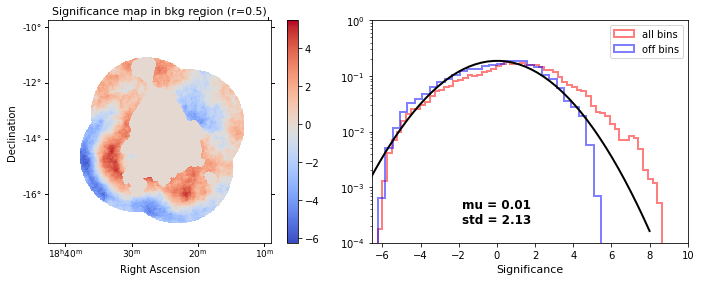

In [59]:
estimator = ExcessMapEstimator(
    correlation_radius=0.5 * u.deg,
    energy_edges=[Elow, Ehigh]*u.TeV, 
    selection_optional=None)
lima_maps_iter3_05 = estimator.run(stacked_iter3)

significance_map_iter3 = lima_maps_iter3_05["sqrt_ts"]
sqrt_ts_image_iter3 = significance_map_iter3.get_image_by_idx((0,))

mask_image = exclusion_enlarged_iter3.interp_to_geom(significance_map_iter3.geom).sum_over_axes()
mask_image.data = mask_image.data.astype(bool)
significance_map_off = significance_map_iter3 * mask_image

significance_all = significance_map_iter3.data[np.isfinite(significance_map_iter3.data)]
significance_off = significance_map_off.data[
    np.isfinite(significance_map_off.data)]
significance_off= significance_off[significance_off != 0]


fig = plt.figure(figsize=(12,9))
fig.tight_layout()


gaus_width = "0.02 deg"
lw = 1.2

#### Significance map #### cmap="coolwarm"
ax1 = plt.subplot(221, projection=sqrt_ts_image_iter3.geom.wcs)
significance_map_off.plot(ax=ax1, add_cbar=True, cmap="coolwarm")

# Define labels
label_markersize, fontsize  = 6,6
#legend_elements = [Line2D([0], [0], marker="o", color='none', label='Masks around HGPS sources',
#                          markeredgecolor='blue', markersize=label_markersize)]
#ax1.legend(handles=legend_elements, fancybox=True, 
#           framealpha=1.0, loc = 'upper left', fontsize=fontsize, edgecolor='black')

ax1.tick_params(axis='both', which='major', labelsize=9)
ax1.set_xlabel('Right Ascension', fontsize=10)
ax1.set_ylabel('Declination', fontsize=10)
ax1.set_title('Significance map in bkg region (r=0.5)', fontsize=11)


#### off distribution ###
ax2 = plt.subplot(222)
plt.hist(
    significance_all,
    density=True,
    alpha=0.5,
    color="red",
    label="all bins",
    bins=60,
    histtype='step',
    linewidth=2
)

plt.hist(
    significance_off,
    density=True,
    alpha=0.5,
    color="blue",
    label="off bins",
    bins=30,
    histtype='step',
    linewidth=2
)

# Now, fit the off distribution with a Gaussian
from scipy.stats import norm
mu, std = norm.fit(significance_off)
x = np.linspace(-8, 8, 50)
p = norm.pdf(x, mu, std)
plt.plot(x, p, lw=2, color="black")
ax2.legend()
ax2.set_xlabel('Significance', fontsize=11)
plt.yscale("log")
plt.ylim(1e-4, 1)
xmin, xmax = np.min(significance_all), np.max(significance_all)
plt.xlim(xmin-0.3, 10)



#log.write(f"Fit results: mu = {mu:.2f}, std = {std:.2f}\n")
print(f"Fit results: mu = {mu:.2f}, std = {std:.2f}")

ax2.text(0, 2e-4, f"mu = {mu:.2f}\nstd = {std:.2f}", horizontalalignment='center',
     verticalalignment='bottom', fontweight = "bold", fontsize=12)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.12, hspace=None)
plt.savefig(os.path.join(plot_dir,'off_excess_and_sign_maps_iter3_05deg.png'), dpi=dpi, bbox_inches='tight')

# Run the data reduction 4 with an intertive mask

Text(0.5, 0, 'Right Ascension')

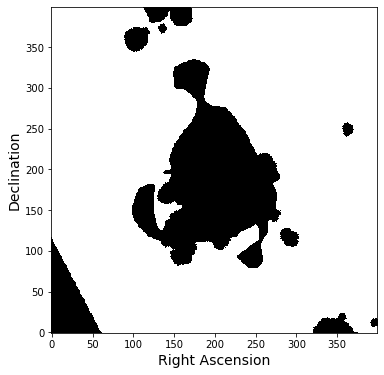

In [60]:
# Enlarge exclusion mask
exclusion_enlarged_iter4 = exclusion_enlarged_iter3.slice_by_idx({"energy" : 0}).copy()
res = lima_maps_iter3_05['sqrt_ts'].sum_over_axes(keepdims=False)
res.data = np.nan_to_num(res.data)
mask_map_significance = res.copy()
mask_map_significance.data = ~apply_hysteresis_threshold(
#             mask_map_significance.smooth(width="0.05 deg").data,
            mask_map_significance.smooth(width="0.1 deg").data,
            low=Low_Thres,
            high=High_Thres)
exclusion_enlarged_iter4 *= mask_map_significance

#import pickle
#f = open(b"total_mask_map_iter2.txt","wb") # Pickling
#pickle.dump(exclusion_enlarged_iter2, f)
#f.close()

#with open("masks.txt", "rb") as fp:   # Unpickling
#    total_mask_map = pickle.load(fp)


plt.figure(figsize=figsize)
ax=plt.subplot(111)
exclusion_enlarged_iter4.sum_over_axes().plot(ax=ax)
plt.ylabel('Declination', fontsize=label_fontsize)
plt.xlabel('Right Ascension', fontsize=label_fontsize)
#plt.savefig(os.path.join(plot_dir,'exclusion_masks_iter3.png'), dpi=dpi, bbox_inches='tight')

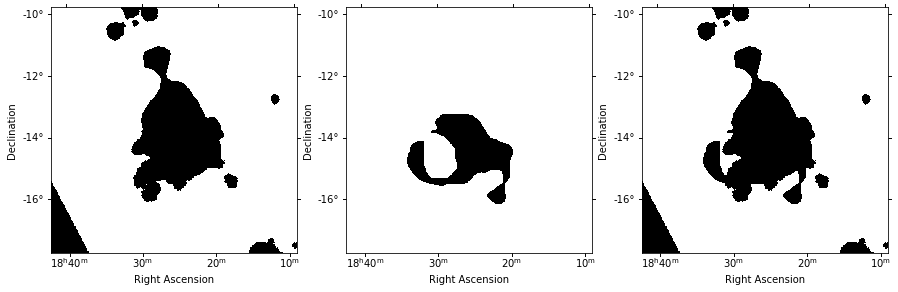

In [62]:
plt.figure(figsize=(15, 5))

wcs = lima_maps_iter3_05['sqrt_ts'].geom.wcs

ax1 = plt.subplot(131, projection=wcs)
exclusion_enlarged_iter3.slice_by_idx({"energy" : 0}).plot(ax=ax1)

ax2 = plt.subplot(132, projection=wcs)
mask_map_significance.plot(ax=ax2);

ax3 = plt.subplot(133, projection=wcs)
exclusion_enlarged_iter4.plot(ax=ax3);

### Define FoVBackgroundMaker with exclusion masks

In [63]:
from gammapy.modeling.models import PowerLawNormSpectralModel
# modify default value on the class level
PowerLawNormSpectralModel.tilt.frozen = False
pwl = PowerLawNormSpectralModel()
print(pwl)
maker_fov = FoVBackgroundMaker(method="fit", exclusion_mask=exclusion_enlarged_iter4)

PowerLawNormSpectralModel

  type      name     value    unit   error   min max frozen link
-------- --------- ---------- ---- --------- --- --- ------ ----
spectral      norm 1.0000e+00      0.000e+00 nan nan  False     
spectral      tilt 0.0000e+00      0.000e+00 nan nan  False     
spectral reference 1.0000e+00  TeV 0.000e+00 nan nan   True     


### Run the data reduction

In [64]:
path = Path(plot_dir)
path.mkdir(exist_ok=True)

bkg_norms_iter4 = open(path /  f"bkg_norms_iter4.txt", 'w')
prb_runs_iter4 = open(path /  f"prb_runs_iter4.txt", 'w')

In [65]:
%%time

for obs in observations:
    try:
     # First a cutout of the target map is produced
       cutout = stacked_iter4.cutout(
       obs.pointing_radec, width=2 * offset_max, name=f"obs-{obs.obs_id}", mode="partial") 
    # A MapDataset is filled in this cutout geometry
       dataset_iter4 = maker.run(cutout, obs)
    # The data quality cut is applied
       dataset_iter4 = maker_safe_mask.run(dataset_iter4, obs)
    # fit background model
       dataset_iter4 = maker_fov.run(dataset_iter4)
       norm = dataset_iter4.models[0].spectral_model.norm.value
       norm_err = dataset_iter4.models[0].spectral_model.norm.error
       tilt = dataset_iter4.models[0].spectral_model.tilt.value
       tilt_err = dataset_iter4.models[0].spectral_model.tilt.error
       #print(
       # f"Background norm obs {obs.obs_id}: {dataset_iter1.background_model.parameters['norm'].value:.2f}")
    #if the background norm is completely off scale don't stack run
       if np.abs(norm-1.)>0.5:
           print(f"Dropping run - Bad norm(n={norm}).")
           continue
       if norm_err/norm>0.3:
           print(f"Dropping run - Large error on norm(n_err/n={norm_err/norm}).")
           continue
       if np.abs(tilt_err/tilt)>0.2:
          print("Dropping run - Large error on tilt (err_t/t={tilt_err/tilt}.")
          continue
       #if np.abs(tilt)>0.5:
       #   print("Dropping run - Bad tilt.")
       #    continue
       bkg_norms_iter4.write(f"{norm} \t {norm_err} \t {tilt}\n") 
       #print(dataset_iter1.background_model.parameters["norm"].value, dataset_iter1.background_model.parameters["tilt"].value)
     # The resulting dataset cutout is stacked onto the final one
       stacked_iter4.stack(dataset_iter4)
    except:
        prb_runs_iter4.write(f"Error with {obs.obs_id}\n")
        print(f"Error with {obs.obs_id}")
        pass
  
bkg_norms_iter4.close()
prb_runs_iter4.close()

Dropping run - Large error on norm(n_err/n=0.6759766142715846).
Dropping run - Bad norm(n=2.109871426183052).
Dropping run - Bad norm(n=2.9176376663744783).
Dropping run - Bad norm(n=1.6358982165842826).
Dropping run - Bad norm(n=1.8717557832991647).
Dropping run - Large error on tilt (err_t/t={tilt_err/tilt}.
Dropping run - Bad norm(n=1.854349864396009).
Dropping run - Bad norm(n=1.7302569744350125).
Dropping run - Bad norm(n=2.7311205794548057).
Dropping run - Bad norm(n=1.6122527108584013).
Dropping run - Bad norm(n=1.9021667763991263).
Dropping run - Bad norm(n=1.6058545706766085).
Dropping run - Large error on tilt (err_t/t={tilt_err/tilt}.
Dropping run - Large error on norm(n_err/n=0.3140003705515961).
Dropping run - Bad norm(n=1.8796479499312).
Dropping run - Bad norm(n=1.6785951004812416).
Dropping run - Bad norm(n=1.987250867836429).
Dropping run - Bad norm(n=3.2885255006434955).
Dropping run - Bad norm(n=1.6545658301251995).
Dropping run - Bad norm(n=1.6057496480530753).
Drop

FoVBackgroundMaker failed. Fit did not converge for obs-22473. Setting mask to False.


Dropping run - Bad norm(n=324320.371442219).
Dropping run - Bad norm(n=2.28431956903101).
Dropping run - Large error on norm(n_err/n=0.539643256423088).
Dropping run - Large error on norm(n_err/n=0.8522321982716963).
Dropping run - Large error on norm(n_err/n=0.32028436980993313).
Dropping run - Bad norm(n=0.4898021849520599).
Dropping run - Bad norm(n=0.4176994080644112).
Dropping run - Large error on norm(n_err/n=0.3814607482726729).
Dropping run - Bad norm(n=1.6284694942434113).
Dropping run - Bad norm(n=1.550250561630298).
Dropping run - Large error on tilt (err_t/t={tilt_err/tilt}.
Dropping run - Large error on norm(n_err/n=0.4380706412806768).
Dropping run - Large error on norm(n_err/n=0.5457071909814367).
Dropping run - Large error on tilt (err_t/t={tilt_err/tilt}.
Dropping run - Bad norm(n=1.906357917088784).
Dropping run - Bad norm(n=1.749240247318679).
Dropping run - Bad norm(n=1.8196613154927284).
Dropping run - Bad norm(n=1.5718324427154307).
Dropping run - Large error on n

In [66]:
load_textdata = np.loadtxt(path / 'bkg_norms_iter4.txt')
norm, norm_err,  tilt = np.transpose(load_textdata)

#normal_norms = []
#for norm in list(range(len(norms))):
#    if norms[norm]>0.5 and norms[norm]<1.5:
#        normal_norms.append(norms[norm])

#run_list.close()

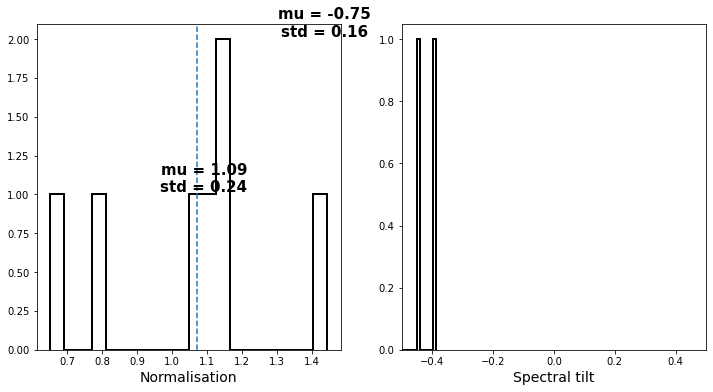

In [67]:
plt.figure(figsize=(12,6))

ax1 = plt.subplot(121)
ax1.hist(norm, density=False, histtype='step', bins=20, linewidth=2, color = "green", ec="black")
median = np.median(norm)
std = np.std(norm)
ax1.axvline(x=median-0.02, ymin=0, ymax=10, linestyle='dashed')
ax1.text(median, 1, f"mu = {median:.2f}\nstd = {std:.2f}", horizontalalignment='center',
     verticalalignment='bottom', fontweight = "bold", fontsize=15)
ax1.set_xlabel('Normalisation', fontsize=label_fontsize)
#plt.xlim(0.5, 1.5)

ax2 = plt.subplot(122)
ax2.hist(tilt, density=False, histtype='step', bins=40, linewidth=2, color = "green", ec="black")
median = np.median(tilt)
std = np.std(tilt)
ax2.axvline(x=median-0.02, ymin=0, ymax=10, linestyle='dashed')
ax2.text(median, 1, f"mu = {median:.2f}\nstd = {std:.2f}", horizontalalignment='center',
     verticalalignment='bottom', fontweight = "bold", fontsize=15)
ax2.set_xlabel('Spectral tilt', fontsize=label_fontsize)
ax2.set_xlim(-0.5, 0.5)

plt.savefig(os.path.join(plot_dir,'norms_distribution_iter4.png'), dpi=dpi, bbox_inches='tight')

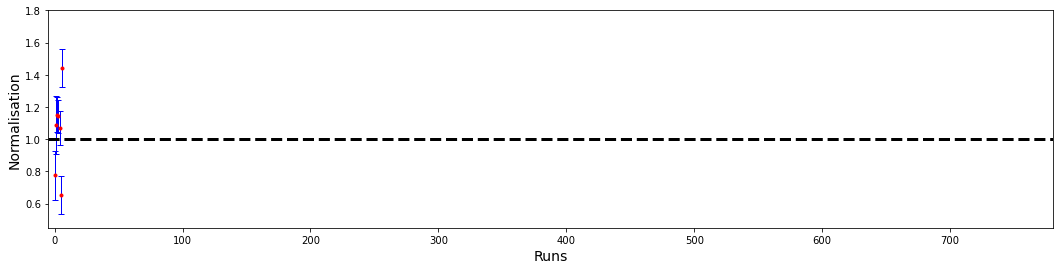

In [68]:
fig = plt.figure(figsize=(18,4))
fig.tight_layout()

#linestyle = '-'
index = list(range(0, len(norm)))
np_index = np.array(index)
#plt.errorbar(np_index, norm, ms=4*markersize, fmt='blue', linewidth=2.0, capsize=5)


plt.errorbar(np_index, norm, norm_err, 
            ms=1, linewidth=1.0, capsize=3, fmt='o', color='blue')

plt.errorbar(np_index, norm,
             ms=3, fmt='o', color='red')

plt.axhline(y = 1, color ="black", linestyle ="--", linewidth=3)

plt.xlabel('Runs', fontsize=14)
plt.ylabel('Normalisation', fontsize=14)
plt.xlim(-5, 780)
plt.ylim(0.45, 1.8)

plt.savefig(os.path.join(plot_dir,'norms_iter4.png'), dpi=dpi, bbox_inches='tight')

### Save into disk

In [69]:
path = Path("dataset")
path.mkdir(exist_ok=True)

filename = path / "reduced_dataset_iter4.fits.gz"
stacked_iter4.write(filename, overwrite=True)

### Read MapDataset from the disk

In [70]:
path = Path("dataset")
filename = path / "reduced_dataset_iter4.fits.gz"
stacked_iter4 = MapDataset.read(filename, name='stacked')
print(stacked_iter4)

MapDataset
----------

  Name                            : stacked 

  Total counts                    : 10658 
  Total background counts         : 9720.69
  Total excess counts             : 937.31

  Predicted counts                : 9720.69
  Predicted background counts     : 9720.69
  Predicted excess counts         : nan

  Exposure min                    : 1.49e-04 m2 s
  Exposure max                    : 5.82e+09 m2 s

  Number of total bins            : 1440000 
  Number of fit bins              : 546512 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




### Checking on/off histograms

Fit results: mu = -0.09, std = 1.10


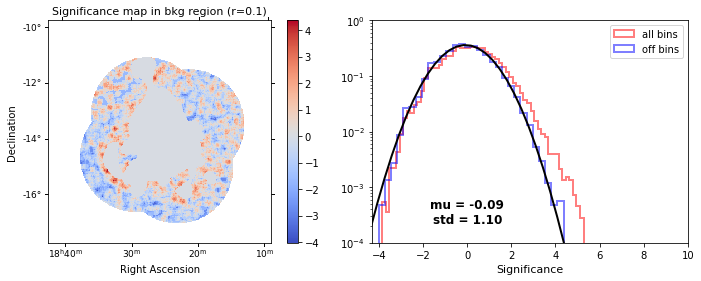

In [71]:
estimator = ExcessMapEstimator(
    correlation_radius=0.1 * u.deg,
    energy_edges=[Elow, Ehigh]*u.TeV, 
    selection_optional=None)
lima_maps_iter4 = estimator.run(stacked_iter4)

significance_map_iter4 = lima_maps_iter4["sqrt_ts"]
sqrt_ts_image_iter4 = significance_map_iter4.get_image_by_idx((0,))

mask_image = exclusion_enlarged_iter4.interp_to_geom(significance_map_iter4.geom).sum_over_axes()
mask_image.data = mask_image.data.astype(bool)
significance_map_off = significance_map_iter4 * mask_image

significance_all = significance_map_iter4.data[np.isfinite(significance_map_iter4.data)]
significance_off = significance_map_off.data[
    np.isfinite(significance_map_off.data)]
significance_off= significance_off[significance_off != 0]


fig = plt.figure(figsize=(12,9))
fig.tight_layout()


gaus_width = "0.02 deg"
lw = 1.2

#### Significance map #### cmap="coolwarm"
ax1 = plt.subplot(221, projection=sqrt_ts_image_iter4.geom.wcs)
significance_map_off.plot(ax=ax1, add_cbar=True, cmap="coolwarm")

# Define labels
label_markersize, fontsize  = 6,6
#legend_elements = [Line2D([0], [0], marker="o", color='none', label='Masks around HGPS sources',
#                          markeredgecolor='blue', markersize=label_markersize)]
#ax1.legend(handles=legend_elements, fancybox=True, 
#           framealpha=1.0, loc = 'upper left', fontsize=fontsize, edgecolor='black')

ax1.tick_params(axis='both', which='major', labelsize=9)
ax1.set_xlabel('Right Ascension', fontsize=10)
ax1.set_ylabel('Declination', fontsize=10)
ax1.set_title('Significance map in bkg region (r=0.1)', fontsize=11)


#### off distribution ###
ax2 = plt.subplot(222)
plt.hist(
    significance_all,
    density=True,
    alpha=0.5,
    color="red",
    label="all bins",
    bins=60,
    histtype='step',
    linewidth=2
)

plt.hist(
    significance_off,
    density=True,
    alpha=0.5,
    color="blue",
    label="off bins",
    bins=30,
    histtype='step',
    linewidth=2
)

# Now, fit the off distribution with a Gaussian
from scipy.stats import norm
mu, std = norm.fit(significance_off)
x = np.linspace(-8, 8, 50)
p = norm.pdf(x, mu, std)
plt.plot(x, p, lw=2, color="black")
ax2.legend()
ax2.set_xlabel('Significance', fontsize=11)
plt.yscale("log")
plt.ylim(1e-4, 1)
xmin, xmax = np.min(significance_all), np.max(significance_all)
plt.xlim(xmin-0.3, 10)



#log.write(f"Fit results: mu = {mu:.2f}, std = {std:.2f}\n")
print(f"Fit results: mu = {mu:.2f}, std = {std:.2f}")

ax2.text(0, 2e-4, f"mu = {mu:.2f}\nstd = {std:.2f}", horizontalalignment='center',
     verticalalignment='bottom', fontweight = "bold", fontsize=12)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.12, hspace=None)
plt.savefig(os.path.join(plot_dir,'off_excess_and_sign_maps_iter4_01deg.png'), dpi=dpi, bbox_inches='tight')

Fit results: mu = -0.04, std = 1.38


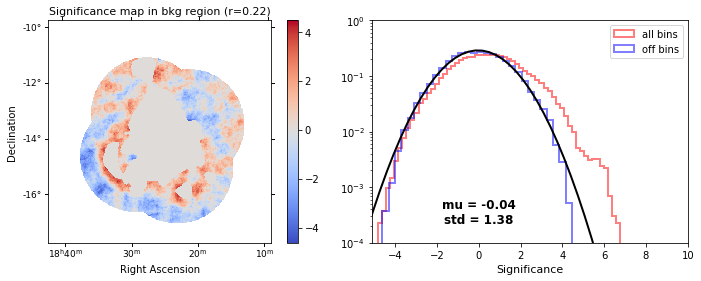

In [72]:
estimator = ExcessMapEstimator(
    correlation_radius=0.22 * u.deg,
    energy_edges=[Elow, Ehigh]*u.TeV, 
    selection_optional=None)
lima_maps_iter4 = estimator.run(stacked_iter4)

significance_map_iter4 = lima_maps_iter4["sqrt_ts"]
sqrt_ts_image_iter4 = significance_map_iter4.get_image_by_idx((0,))

mask_image = exclusion_enlarged_iter4.interp_to_geom(significance_map_iter4.geom).sum_over_axes()
mask_image.data = mask_image.data.astype(bool)
significance_map_off = significance_map_iter4 * mask_image

significance_all = significance_map_iter4.data[np.isfinite(significance_map_iter4.data)]
significance_off = significance_map_off.data[
    np.isfinite(significance_map_off.data)]
significance_off= significance_off[significance_off != 0]


fig = plt.figure(figsize=(12,9))
fig.tight_layout()


gaus_width = "0.02 deg"
lw = 1.2

#### Significance map #### cmap="coolwarm"
ax1 = plt.subplot(221, projection=sqrt_ts_image_iter4.geom.wcs)
significance_map_off.plot(ax=ax1, add_cbar=True, cmap="coolwarm")

# Define labels
label_markersize, fontsize  = 6,6
#legend_elements = [Line2D([0], [0], marker="o", color='none', label='Masks around HGPS sources',
#                          markeredgecolor='blue', markersize=label_markersize)]
#ax1.legend(handles=legend_elements, fancybox=True, 
#           framealpha=1.0, loc = 'upper left', fontsize=fontsize, edgecolor='black')

ax1.tick_params(axis='both', which='major', labelsize=9)
ax1.set_xlabel('Right Ascension', fontsize=10)
ax1.set_ylabel('Declination', fontsize=10)
ax1.set_title('Significance map in bkg region (r=0.22)', fontsize=11)


#### off distribution ###
ax2 = plt.subplot(222)
plt.hist(
    significance_all,
    density=True,
    alpha=0.5,
    color="red",
    label="all bins",
    bins=60,
    histtype='step',
    linewidth=2
)

plt.hist(
    significance_off,
    density=True,
    alpha=0.5,
    color="blue",
    label="off bins",
    bins=30,
    histtype='step',
    linewidth=2
)

# Now, fit the off distribution with a Gaussian
from scipy.stats import norm
mu, std = norm.fit(significance_off)
x = np.linspace(-8, 8, 50)
p = norm.pdf(x, mu, std)
plt.plot(x, p, lw=2, color="black")
ax2.legend()
ax2.set_xlabel('Significance', fontsize=11)
plt.yscale("log")
plt.ylim(1e-4, 1)
xmin, xmax = np.min(significance_all), np.max(significance_all)
plt.xlim(xmin-0.3, 10)



#log.write(f"Fit results: mu = {mu:.2f}, std = {std:.2f}\n")
print(f"Fit results: mu = {mu:.2f}, std = {std:.2f}")

ax2.text(0, 2e-4, f"mu = {mu:.2f}\nstd = {std:.2f}", horizontalalignment='center',
     verticalalignment='bottom', fontweight = "bold", fontsize=12)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.12, hspace=None)
plt.savefig(os.path.join(plot_dir,'off_excess_and_sign_maps_iter4_022deg.png'), dpi=dpi, bbox_inches='tight')

Fit results: mu = 0.11, std = 1.99


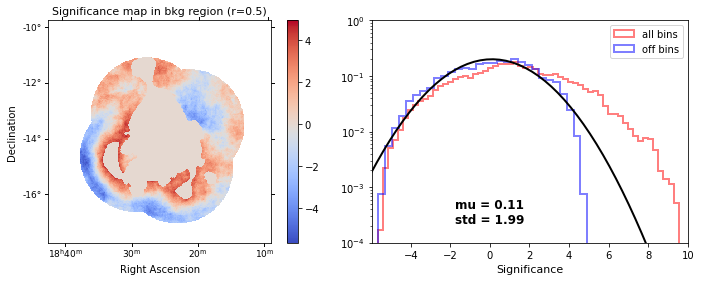

In [73]:
estimator = ExcessMapEstimator(
    correlation_radius=0.5 * u.deg,
    energy_edges=[Elow, Ehigh]*u.TeV, 
    selection_optional=None)
lima_maps_iter4 = estimator.run(stacked_iter4)

significance_map_iter4 = lima_maps_iter4["sqrt_ts"]
sqrt_ts_image_iter4 = significance_map_iter4.get_image_by_idx((0,))

mask_image = exclusion_enlarged_iter4.interp_to_geom(significance_map_iter4.geom).sum_over_axes()
mask_image.data = mask_image.data.astype(bool)
significance_map_off = significance_map_iter4 * mask_image

significance_all = significance_map_iter4.data[np.isfinite(significance_map_iter4.data)]
significance_off = significance_map_off.data[
    np.isfinite(significance_map_off.data)]
significance_off= significance_off[significance_off != 0]


fig = plt.figure(figsize=(12,9))
fig.tight_layout()


gaus_width = "0.02 deg"
lw = 1.2

#### Significance map #### cmap="coolwarm"
ax1 = plt.subplot(221, projection=sqrt_ts_image_iter4.geom.wcs)
significance_map_off.plot(ax=ax1, add_cbar=True, cmap="coolwarm")

# Define labels
label_markersize, fontsize  = 6,6
#legend_elements = [Line2D([0], [0], marker="o", color='none', label='Masks around HGPS sources',
#                          markeredgecolor='blue', markersize=label_markersize)]
#ax1.legend(handles=legend_elements, fancybox=True, 
#           framealpha=1.0, loc = 'upper left', fontsize=fontsize, edgecolor='black')

ax1.tick_params(axis='both', which='major', labelsize=9)
ax1.set_xlabel('Right Ascension', fontsize=10)
ax1.set_ylabel('Declination', fontsize=10)
ax1.set_title('Significance map in bkg region (r=0.5)', fontsize=11)


#### off distribution ###
ax2 = plt.subplot(222)
plt.hist(
    significance_all,
    density=True,
    alpha=0.5,
    color="red",
    label="all bins",
    bins=60,
    histtype='step',
    linewidth=2
)

plt.hist(
    significance_off,
    density=True,
    alpha=0.5,
    color="blue",
    label="off bins",
    bins=30,
    histtype='step',
    linewidth=2
)

# Now, fit the off distribution with a Gaussian
from scipy.stats import norm
mu, std = norm.fit(significance_off)
x = np.linspace(-8, 8, 50)
p = norm.pdf(x, mu, std)
plt.plot(x, p, lw=2, color="black")
ax2.legend()
ax2.set_xlabel('Significance', fontsize=11)
plt.yscale("log")
plt.ylim(1e-4, 1)
xmin, xmax = np.min(significance_all), np.max(significance_all)
plt.xlim(xmin-0.3, 10)



#log.write(f"Fit results: mu = {mu:.2f}, std = {std:.2f}\n")
print(f"Fit results: mu = {mu:.2f}, std = {std:.2f}")

ax2.text(0, 2e-4, f"mu = {mu:.2f}\nstd = {std:.2f}", horizontalalignment='center',
     verticalalignment='bottom', fontweight = "bold", fontsize=12)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.12, hspace=None)
plt.savefig(os.path.join(plot_dir,'off_excess_and_sign_maps_iter4_05deg.png'), dpi=dpi, bbox_inches='tight')

array([[<WCSAxesSubplot:title={'center':'Energy 2.0 TeV - 3.2 TeV '}, ylabel='Declination'>,
        <WCSAxesSubplot:title={'center':'Energy 3.2 TeV - 5.0 TeV '}>,
        <WCSAxesSubplot:title={'center':'Energy 5.0 TeV - 7.8 TeV '}>],
       [<WCSAxesSubplot:title={'center':'Energy 7.8 TeV - 12.3 TeV '}, ylabel='Declination'>,
        <WCSAxesSubplot:title={'center':'Energy 12.3 TeV - 19.4 TeV '}>,
        <WCSAxesSubplot:title={'center':'Energy 19.4 TeV - 30.7 TeV '}>],
       [<WCSAxesSubplot:title={'center':'Energy 30.7 TeV - 48.3 TeV '}, xlabel='Right Ascension', ylabel='Declination'>,
        <WCSAxesSubplot:title={'center':'Energy 48.3 TeV - 76.1 TeV '}, xlabel='Right Ascension'>,
        <WCSAxesSubplot:title={'center':'Energy 76.1 TeV - 120.0 TeV '}, xlabel='Right Ascension'>]],
      dtype=object)

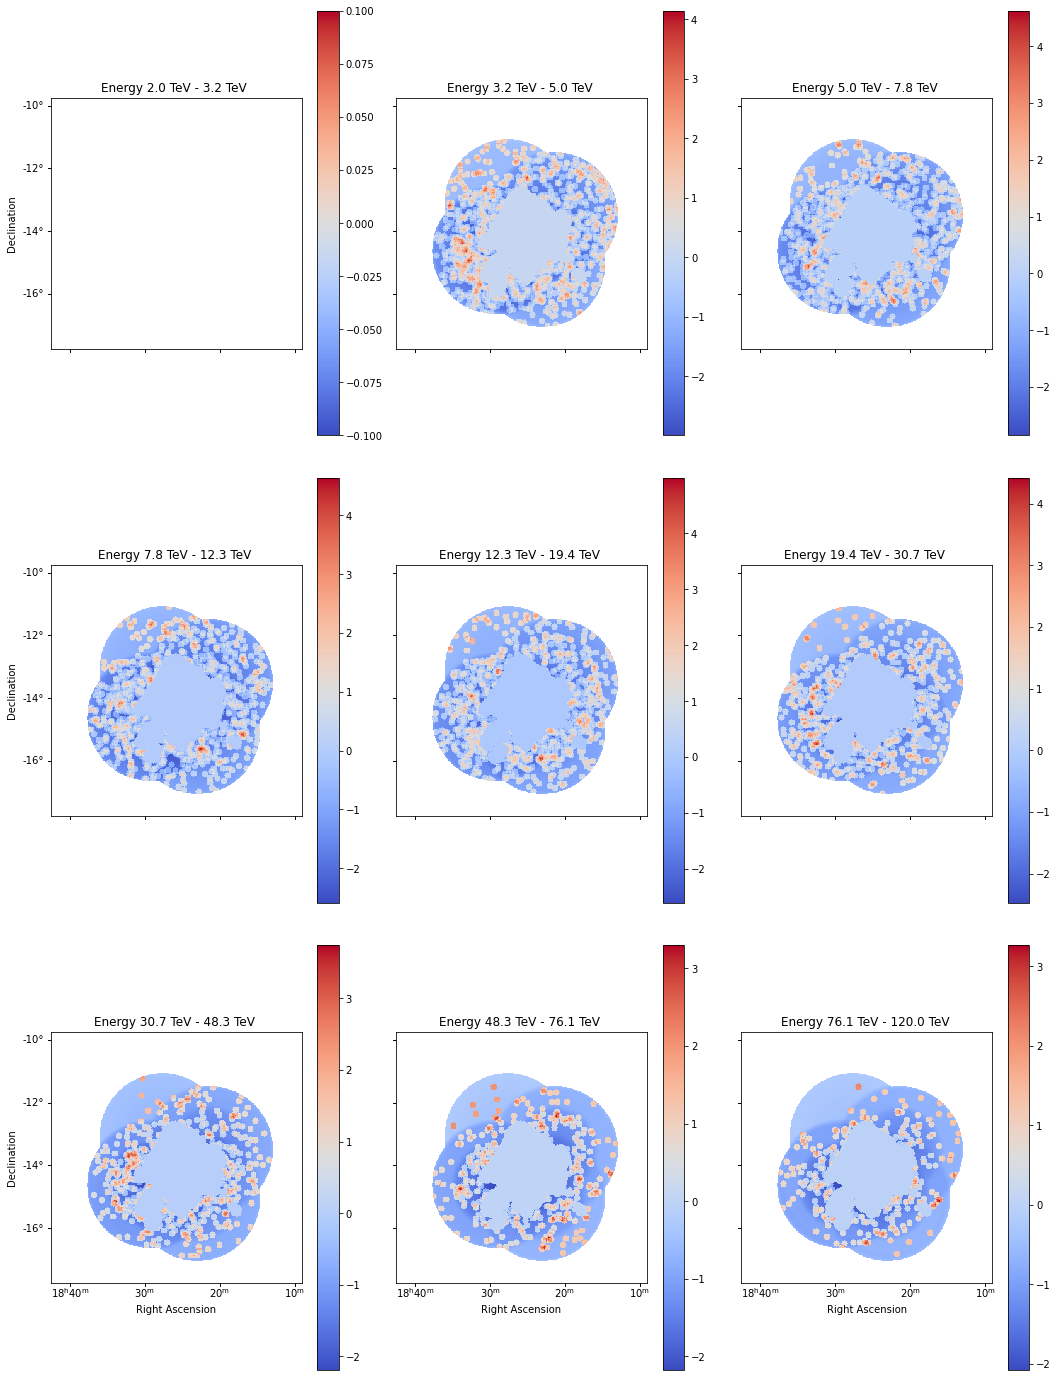

In [74]:
estimator = ExcessMapEstimator(
    correlation_radius=0.1 * u.deg,
    selection_optional=None,
#     energy_edges=[1.3335214, 1.7782794, 2.3713737, 3.1622777, 4.216965, 5.6234133, 7.4989421, 10, 
#                   13.335214, 17.782794, 23.713737, 31.622777, 42.16965, 56.234133, 74.989421, 100] * u.TeV)
    energy_edges=[2., 3.1521172, 4.96792142, 7.82973528, 12.34012163,
                  19.44875482, 30.6523773, 48.30994285, 76.1393009, 120.] * u.TeV)
    
lima_maps_iter4 = estimator.run(stacked_iter4)


bkg_sqrt = lima_maps_iter4["sqrt_ts"] * mask_map.interp_to_geom(lima_maps_iter4["sqrt_ts"].geom)


#mask_image = mask_map.sum_over_axes()
#mask_image.data = mask_image.data.astype(bool)


#bkg_sqrt = lima_maps_iter1["sqrt_ts"] * mask_image
bkg_sqrt.plot_grid(
    figsize=(18, 25), cmap="coolwarm", add_cbar=True)
#plt.savefig(os.path.join(output,'residual_map_in_energy_bins.png'), dpi=dpi, bbox_inches='tight')